# MIMIC-II IAC Introduction

This tutorial explores the **M**ultiparameter **I**ntelligent **M**onitoring in **I**ntensive **C**are II (**MIMIC-II**) **I**ndwelling **A**rterial **C**atheters (**IAC**) dataset, as subset derived from MIMIC-II, the publicly-accessible critical care database. The database was created for the purpose of a case study in the book ["Secondary Analysis of Electronic Health Records"](https://link.springer.com/book/10.1007/978-3-319-43742-2), published by Springer in 2016. In particular, the MIMIC-II IAC dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. 

More details on the dataset such as all included features and their description can be found [here](https://physionet.org/content/mimic2-iaccd/1.0/)

Overview of the MIMIC-II database extracted from the original book:


<img src="./images/MIMIC-II-database-structure.png" width="35%" height="auto">


In this tutorial we want to explore the MIMIC-II IAC dataset using ehrapy to identidy patient groups and their associated features. 

The major steps of ehrapy analysis include:
&nbsp;
1. Preprocessing and quality control (QC)

3. Dimensionality reduction
4. Batch effect identification
5. Clustering 
7. Additional downstream analysis


&nbsp;

Before we start with the analysis of the MIMIC-II IAC dataset, we set up our environment including the import of packages and preparation of the dataset.

## Environment setup

### imports

Enusre that the latest version of ehrapy is installed. A list of all dependency versions can be found at the end of this tutorial.

In [1]:
import ehrapy as ep
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams


In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)

### MIMIC-II IAC dataset loading

ehrapy offers several [datasets](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#data) in AnnData format that can be used out of the box.
In this tutorial we will use the MIMIC-II IAC dataset with unencoded features. ehrapy's default encoding is a simple one-hot encoding in this case. More details on encoding can be seen in the next step.

In [3]:
import pandas as pd
df = pd.read_csv( "../ehrapy_data/ehrapy_mimic2.csv",   index_col=False)

It is also possible to get the MIMIC-II IAC dataset already pre-encoded by setting the encoded flag to 'True'.

In [4]:
df

aline_flg  icu_los_day  hospital_los_day       age  gender_num  \
0             1         7.63                13  72.36841         1.0   
1             0         1.14                 1  64.92076         0.0   
2             0         2.86                 5  36.50000         0.0   
3             1         0.58                 3  44.49191         0.0   
4             1         1.75                 5  23.74217         1.0   
...         ...          ...               ...       ...         ...   
1771          1        26.90                31  68.48606         1.0   
1772          1         3.70                 4  72.44020         0.0   
1773          0         2.87                 3  22.70098         1.0   
1774          1        22.63                23  53.74423         1.0   
1775          1         2.08                10  60.87331         0.0   

      weight_first        bmi  sapsi_first  sofa_first service_unit  ...  \
0             75.0  29.912791         15.0         9.0         SICU  ...   
1             55.0  20.121312          NaN         5.0         MICU  ...   
2             70.0  27.118272         16.0         5.0         MICU  ...   
3              NaN        NaN         21.0         7.0         SICU  ...   
4             95.2  28.464563         18.0         7.0         SICU  ...   
...            ...        ...          ...         ...          ...  ...   
1771          76.6        NaN         17.0         8.0         MICU  ...   
1772          60.0        NaN         14.0         5.0         SICU  ...   
1773          69.0        NaN         16.0         5.0         MICU  ...   
1774         124.4        NaN         18.0         9.0         SICU  ...   
1775          65.4        NaN         14.0         7.0         MICU  ...   

      platelet_first sodium_first  potassium_first  tco2_first  \
0              354.0        138.0              4.6        15.0   
1                NaN          NaN              NaN         NaN   
2              295.0        144.0              3.9        17.0   
3              262.0        139.0              4.2        31.0   
4               22.0        146.0              3.4        19.0   
...              ...          ...              ...         ...   
1771           294.0        135.0              3.4        23.0   
1772           363.0        138.0              6.3        22.0   
1773           121.0        134.0              4.1        23.0   
1774           374.0        137.0              4.6        21.0   
1775           226.0        139.0              3.9         3.0   

      chloride_first  bun_first  creatinine_first  po2_first  pco2_first  \
0              109.0       41.0               1.6      196.0        39.0   
1                NaN        NaN               NaN        NaN         NaN   
2              101.0       16.0               0.8      298.0        30.0   
3              100.0       16.0               0.5      146.0        23.0   
4              110.0       10.0               1.0      134.0        30.0   
...              ...        ...               ...        ...         ...   
1771           100.0       17.0               0.9      253.0        35.0   
1772           104.0       20.0               0.8      154.0        45.0   
1773           105.0       27.0               0.6        NaN         NaN   
1774            99.0       13.0               1.1       84.0        31.0   
1775           111.0       25.0               1.4      574.0        12.0   

         iv_day_1  
0     2230.875000  
1      600.000000  
2     2086.800293  
3             NaN  
4     2358.244141  
...           ...  
1771   100.117500  
1772   289.950012  
1773   157.500000  
1774    21.770000  
1775  4368.000000  

[1776 rows x 46 columns]

In [5]:
adata = ep.ad.df_to_anndata(df)

2023-07-03 13:56:39,228 - root INFO - Added all columns to `obs`.
2023-07-03 13:56:39,245 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `1776` x `46`.


In [6]:
adata

AnnData object with n_obs × n_vars = 1776 × 46
    uns: 'numerical_columns', 'non_numerical_columns'
    layers: 'original'

In [7]:
#adata = ep.dt.mimic_2(encoded=False)
adata

AnnData object with n_obs × n_vars = 1776 × 46
    uns: 'numerical_columns', 'non_numerical_columns'
    layers: 'original'

The MIMIC-II dataset has 1776 patients with 46 features. 
<br><br><br>
Now that we have our AnnData file ready, we can start the analysis using ehrapy and the first step will be to preprocess the dataset.

## Analysis using ehrapy

### Preprocessing

The dataset contains 46 features as previously mentoined. However, not all features are numerical as some are categorical which need encoding. We first identify categorical (non-numerical features) variables.

In [8]:
adata.uns["non_numerical_columns"]

['service_unit', 'day_icu_intime']

We identified **service_unit** and **day_icu_intime** as categorical features. We will therefore encode them first with one-hot encoding. This ensures that no ordering is preserved for the respective features. ehrapy also offers other [encoding](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#encoding) functions.

In [9]:
adata = ep.pp.encode(
    adata, encodings={"one_hot_encoding": ["service_unit", "day_icu_intime"]}
)

2023-07-03 13:56:39,296 - root INFO - The original categorical values `['service_unit', 'day_icu_intime']` were added to uns.


Output()

2023-07-03 13:56:39,316 - root INFO - Updated the original layer after encoding.
2023-07-03 13:56:39,325 - root INFO - Added `['service_unit', 'day_icu_intime']` columns to `X`.
2023-07-03 13:56:39,329 - root INFO - The original categorical values `['service_unit', 'day_icu_intime']` were added to obs.


In [10]:
adata

AnnData object with n_obs × n_vars = 1776 × 54
    obs: 'service_unit', 'day_icu_intime'
    uns: 'numerical_columns', 'non_numerical_columns', 'encoding_to_var', 'original_values_categoricals', 'var_to_encoding'
    layers: 'original'

After one-hot encoding the two features, we have expanded our matrix from 46 to 54 features.

To verify that we have encoded all features correctly and are ready to proceed, we can use the *type_overview()* function.

In [11]:
ep.ad.type_overview(adata)

Variable names for AnnData object with 1776 obs and 54 vars
╠══ 🔐 Encoded variables
║   ╠══ service_unit -> 3 categories; one hot encoded; original data type: string
║   ╚══ day_icu_intime -> 7 categories; one hot encoded; original data type: string
╚══ 🔓 Unencoded variables
    ╠══ aline_flg -> data type: floating
    ╠══ icu_los_day -> data type: floating
    ╠══ hospital_los_day -> data type: floating
    ╠══ age -> data type: floating
    ╠══ gender_num -> data type: floating
    ╠══ weight_first -> data type: floating
    ╠══ bmi -> data type: floating
    ╠══ sapsi_first -> data type: floating
    ╠══ sofa_first -> data type: floating
    ╠══ service_num -> data type: floating
    ╠══ day_icu_intime_num -> data type: floating
    ╠══ hour_icu_intime -> data type: floating
    ╠══ hosp_exp_flg -> data type: floating
    ╠══ icu_exp_flg -> data type: floating
    ╠══ day_28_flg -> data type: floating
    ╠══ mort_day_censored -> data type: floating
    ╠══ censor_flg -> data type: floating
    ╠══ sepsis_flg -> data type: floating
    ╠══ chf_flg -> data type: floating
    ╠══ afib_flg -> data type: floating
    ╠══ renal_flg -> data type: floating
    ╠══ liver_flg -> data type: floating
    ╠══ copd_flg -> data type: floating
    ╠══ cad_flg -> data type: floating
    ╠══ stroke_flg -> data type: floating
    ╠══ mal_flg -> data type: floating
    ╠══ resp_flg -> data type: floating
    ╠══ map_1st -> data type: floating
    ╠══ hr_1st -> data type: floating
    ╠══ temp_1st -> data type: floating
    ╠══ spo2_1st -> data type: floating
    ╠══ abg_count -> data type: floating
    ╠══ wbc_first -> data type: floating
    ╠══ hgb_first -> data type: floating
    ╠══ platelet_first -> data type: floating
    ╠══ sodium_first -> data type: floating
    ╠══ potassium_first -> data type: floating
    ╠══ tco2_first -> data type: floating
    ╠══ chloride_first -> data type: floating
    ╠══ bun_first -> data type: floating
    ╠══ creatinine_first -> data type: floating
    ╠══ po2_first -> data type: floating
    ╠══ pco2_first -> data type: floating
    ╚══ iv_day_1 -> data type: floating

### Quality Control (QC)

#### Demographics distribution

To see if we have strong differences by demographics, we can check these features in a violin plot.

[Text(0.5, 1.0, 'age distribution by sex (1 = male; 0=female)')]

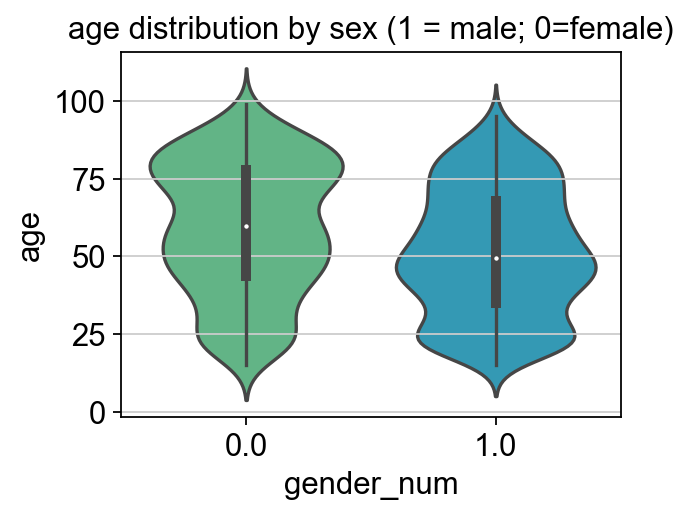

In [12]:
ep.settings.set_figure_params(figsize=(4, 3))
tmp = ep.anndata.anndata_to_df(adata)
sns.violinplot(y=tmp["age"], x=tmp["gender_num"], palette= {0: "#54C285", 1: "#1FA6C9"}).set(title = "age distribution by sex (1 = male; 0=female)")

#### Missing values

ehrapy's *qc_metrics()* function will calculate several useful metrics such as the absolute number and percentages of missing values and properties like the mean/median/min/max of all features. The percentage of missing values is important as features with too many missing values should not be included. 

In [13]:
_ = ep.pp.qc_metrics(adata)
ep.pl.qc_metrics(adata)

2023-07-03 13:56:40,397 - root INFO - Added the calculated metrics to AnnData's `obs` and `var`.


                                             Ehrapy qc metrics of var                                              
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Column name ┃ missing_va… ┃ missing_va… ┃        mean ┃       median ┃ standard_d… ┃          min ┃         max ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│ ehrapycat_… │         0.0 │         0.0 │         nan │          nan │         nan │          nan │         nan │
│   aline_flg │         0.0 │         0.0 │ 0.55405405… │          1.0 │ 0.49706957… │          0.0 │         1.0 │
│ icu_los_day │         0.0 │         0.0 │ 3.34649774… │ 2.185000061… │ 3.35531576… │          0.5 │ 28.2399997… │
│ hospital_l… │         0.0 │         0.0 │ 8.11092342… │          6.0 │ 8.15486189… │          1.0 │       112.0 │
│         age │         0.0 │         0.0 │ 54.3796599… │ 53.67858505… │ 21.0569234… │ 15.18023014… │ 99.1109466… │
│  gender_num │         1.0 │ 0.05630630… │ 0.57746478… │          1.0 │ 0.49396275… │          0.0 │         1.0 │
│ weight_fir… │       110.0 │ 6.19369369… │ 80.0759483… │         77.0 │ 22.4837652… │         30.0 │ 257.600006… │
│         bmi │       466.0 │ 26.2387387… │ 27.8273155… │ 26.32484626… │ 8.20693988… │ 12.78487682… │ 98.7971343… │
│ sapsi_first │        85.0 │ 4.78603603… │ 14.1366055… │         14.0 │ 4.11308538… │          3.0 │        32.0 │
│  sofa_first │         6.0 │ 0.33783783… │ 5.82090395… │          6.0 │ 2.33400634… │          0.0 │        17.0 │
│ service_num │         0.0 │         0.0 │ 0.55292792… │          1.0 │ 0.49719074… │          0.0 │         1.0 │
│ day_icu_in… │         0.0 │         0.0 │ 4.05405405… │          4.0 │ 1.99391117… │          1.0 │         7.0 │
│ hour_icu_i… │         0.0 │         0.0 │ 10.5855855… │          9.0 │ 7.92273324… │          0.0 │        23.0 │
│ hosp_exp_f… │         0.0 │         0.0 │ 0.13738738… │          0.0 │ 0.34425585… │          0.0 │         1.0 │
│ icu_exp_flg │         0.0 │         0.0 │ 0.09572072… │          0.0 │ 0.29420785… │          0.0 │         1.0 │
│  day_28_flg │         0.0 │         0.0 │ 0.15934684… │          0.0 │ 0.36599922… │          0.0 │         1.0 │
│ mort_day_c… │         0.0 │         0.0 │ 614.329825… │        731.0 │ 402.996045… │          0.0 │ 3094.08007… │
│  censor_flg │         0.0 │         0.0 │ 0.72015765… │          1.0 │ 0.44892160… │          0.0 │         1.0 │
│  sepsis_flg │         0.0 │         0.0 │         0.0 │          0.0 │         0.0 │          0.0 │         0.0 │
│     chf_flg │         0.0 │         0.0 │ 0.11993243… │          0.0 │ 0.32488250… │          0.0 │         1.0 │
│    afib_flg │         0.0 │         0.0 │ 0.11655405… │          0.0 │ 0.32088815… │          0.0 │         1.0 │
│   renal_flg │         0.0 │         0.0 │ 0.03378378… 

All properties will be added to the respective layers. Categorical feautres can be found in the **obs** layer, while numerical features are in the **var** layer of the AnnData object. When inspecting both layers, we see that our QC properites were added for each feature, if possible (here just a short representation with *head()* and *tail()* functions).

In [14]:
adata.obs.head(4)

service_unit day_icu_intime  missing_values_abs  missing_values_pct
0         SICU      Friday                      0            0.000000
1         MICU      Saturday                   12           22.222222
2         MICU      Friday                      0            0.000000
3         SICU      Saturday                    3            5.555556

In [15]:
adata.var.tail(4)

missing_values_abs  missing_values_pct         mean  \
creatinine_first                   6            0.337838     1.095706   
po2_first                        186           10.472973   227.623270   
pco2_first                       186           10.472973    43.413836   
iv_day_1                         143            8.051802  1622.907946   

                       median  standard_deviation   min           max  
creatinine_first     0.900000            1.083171   0.0     18.299999  
po2_first          195.000000          144.817841  22.0    634.000000  
pco2_first          41.000000           13.976388   8.0    158.000000  
iv_day_1          1081.529175         1676.615567   0.0  13910.000000

We can also represent the missing values in a histogram for both **obs** and **var** features.

[Text(0.5, 1.0, 'pct of missing values: var')]

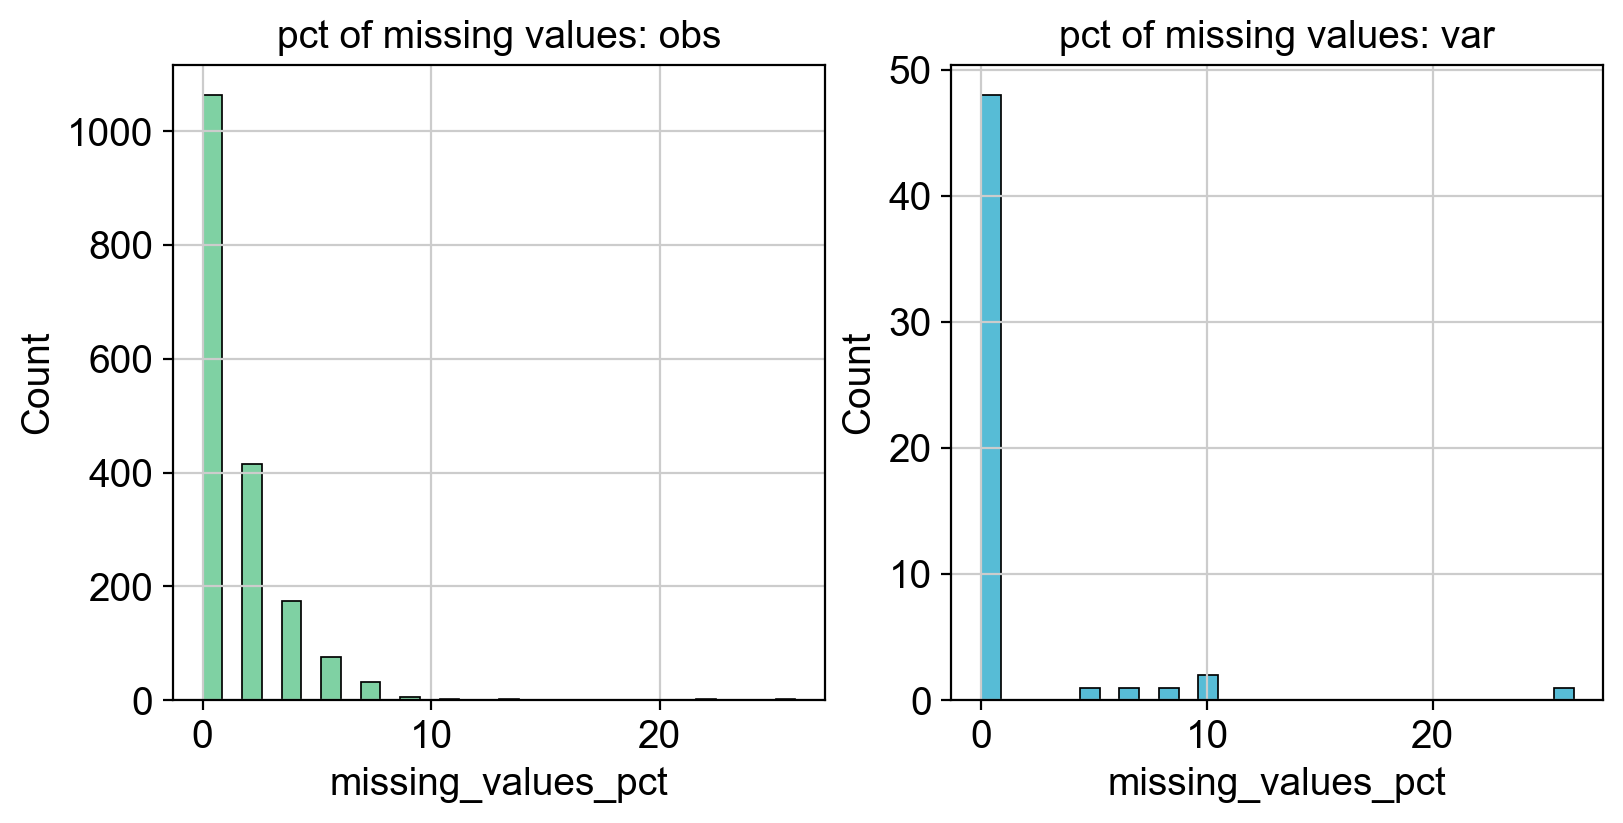

In [16]:
axd = plt.figure(constrained_layout=True, figsize=(8,4), dpi=100).subplot_mosaic(
    """
    AB
    """)

sns.histplot(adata.obs["missing_values_pct"], ax=axd['A'], bins = 30, color = "#54C285").set(title='pct of missing values: obs')
sns.histplot(adata.var["missing_values_pct"], ax=axd['B'], bins = 30, color = "#1FA6C9").set(title='pct of missing values: var')

We can also check which features have the highest percentage of missing values in both **obs** and **vars**.

In [17]:
adata.obs.loc[adata.obs["missing_values_pct"] == adata.obs["missing_values_pct"].max(), :]

service_unit day_icu_intime  missing_values_abs  missing_values_pct
1732         SICU      Thursday                   14           25.925926
1751         MICU      Tuesday                    14           25.925926

In [18]:
adata.var.loc[adata.var["missing_values_pct"] == adata.var["missing_values_pct"].max(), :]

missing_values_abs  missing_values_pct       mean     median  \
bmi                 466           26.238739  27.827316  26.324846   

     standard_deviation        min        max  
bmi             8.20694  12.784877  98.797134

Overall, the percentage of missing values in all features is rather low, however, still some features show missing values.
We suggest to drop features when the percentage of missing values is very high (>60%), since none of them exceed more than 27% (BMI, vars), there is no need to drop any features. 

To fill up the missing values, we perform an imputation. 

ADD INFORMATION IMPUTATION

#### Missing data imputation

ehrapy offers many options to [impute](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#imputation) missing values in an AnnData object.
Here, we use KNN imputation with 5 neighbors (`n_neighbours=5`, the default value).

In [19]:
ep.pp.knn_impute(adata, n_neighbours=5)

scikit-learn-intelex is not available. Install via pip install scikit-learn-intelex  for faster imputations.

Output()

After recalcuating the QC metrices, we can check again the percentage of missing values.

In [20]:
_ = ep.pp.qc_metrics(adata)

2023-07-03 13:56:41,765 - root INFO - Added the calculated metrics to AnnData's `obs` and `var`.


[Text(0.5, 1.0, 'pct of missing values: var'), (0.0, 30.0)]

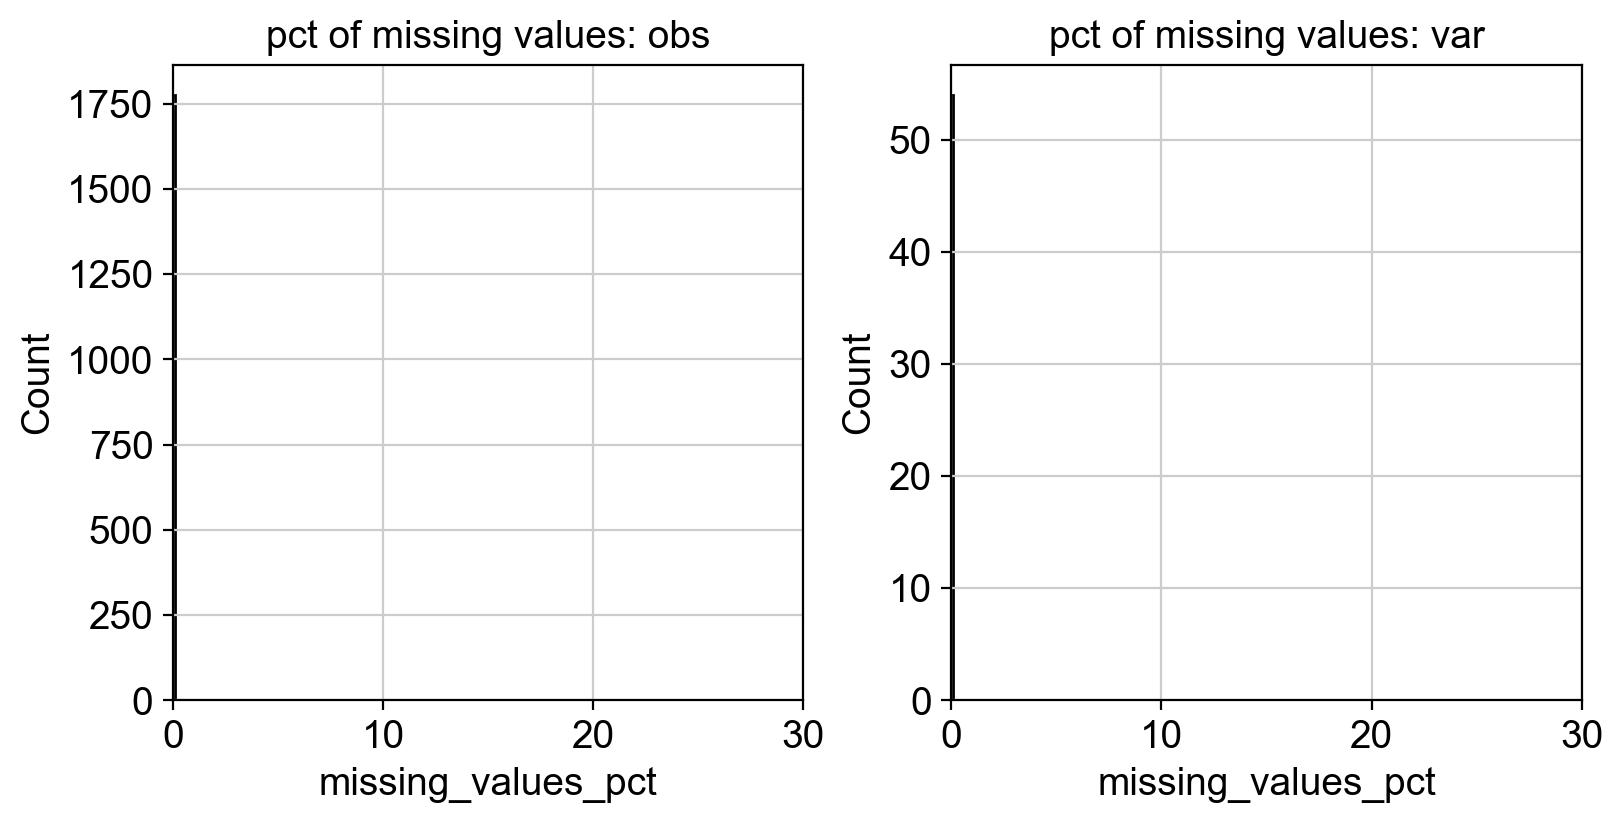

In [21]:
axd = plt.figure(constrained_layout=True, figsize=(8,4), dpi=100).subplot_mosaic(
    """
    AB
    """)

sns.histplot(adata.obs["missing_values_pct"], ax=axd['A'], bins = 5, color = "#54C285").set(title='pct of missing values: obs', xlim=(0, 30))
sns.histplot(adata.var["missing_values_pct"], ax=axd['B'], bins = 5, color = "#1FA6C9").set(title='pct of missing values: var', xlim=(0, 30))

#### Data distribution

Depending on the measurement and the unit of a measurement the value ranges of features may be huge.
Clusterings and differential comparisons especially may be greatly influenced by exceptionally big values. 

[Text(0.5, 1.0, 'maximum values')]

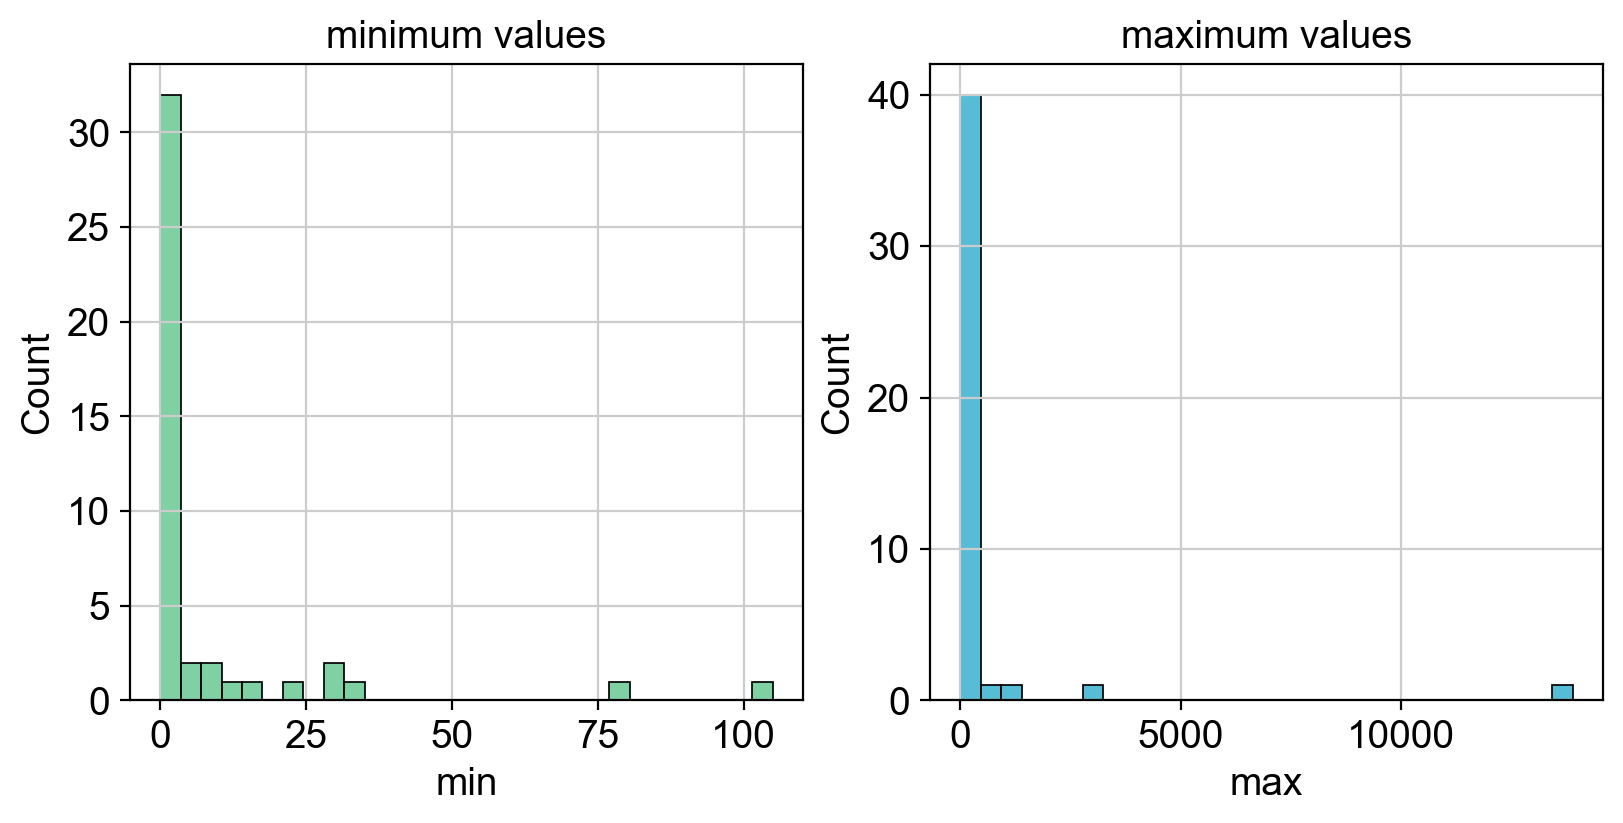

In [22]:
axd = plt.figure(constrained_layout=True, figsize=(8,4), dpi=100).subplot_mosaic(
    """
    AB
    """)

sns.histplot(adata.var["min"], ax=axd['A'], bins = 30, color = "#54C285").set(title='minimum values')
sns.histplot(adata.var["max"], ax=axd['B'], bins = 30, color = "#1FA6C9").set(title='maximum values')

Moreover, features which have a very high coefficient of variation can strongly influence dimensionality reduction. However, since the coefficient of variation performs weak with features that have small means, we only select those which have no small mean. 

In [23]:
adata.var["coefficient.variation"] = (adata.var["standard_deviation"]/adata.var["mean"])*100

In [24]:
adata.var.loc[(adata.var["coefficient.variation"] > 50) & (adata.var["mean"] >50), ]

missing_values_abs  missing_values_pct         mean  \
mort_day_censored                   0                 0.0   614.329825   
po2_first                           0                 0.0   230.324887   
iv_day_1                            0                 0.0  1613.196693   

                   median  standard_deviation   min           max  \
mort_day_censored   731.0          402.996046   0.0   3094.080078   
po2_first           204.0          139.134923  22.0    634.000000   
iv_day_1           1150.0         1619.062172   0.0  13910.000000   

                   coefficient.variation  
mort_day_censored              65.599297  
po2_first                      60.408115  
iv_day_1                      100.363594

The standard deviations and coefficients of variation of the features **iv_day_1** (input fluids by IV on day 1 in mL) and **po2_first** (first PaO_2 in mmHg) are very high with strong spread between minimum and maximum values. These features require normalization. 

### Normalization

ehrapy offers several options to [normalize](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#normalization) data. While it is possible to normalize all numerical values at once with the same normalization function, normalizing only the features with high spread, here **iv_day_1** and **po2_first**, can be sufficient.
Log normalization with an offset of 1 to add pseudocounts seems appropriate.

Note: When features with negative values should be normalized you have to use the *pp.offset_negative_values()* function prior normalization.

In [25]:
ep.pp.log_norm(adata, vars=['iv_day_1', "po2_first"], offset=1)

2023-07-03 13:56:43,065 - root INFO - Column names for numeric variables ['iv_day_1', 'po2_first'] were replaced by [[5.2832036 7.7105975]
 [5.1973915 6.398595 ]
 [5.7004437 7.643866 ]
 ...
 [5.757007  5.0657544]
 [4.4426513 3.125444 ]
 [6.35437   8.38229  ]].


AnnData object with n_obs × n_vars = 1776 × 54
    obs: 'service_unit', 'day_icu_intime', 'missing_values_abs', 'missing_values_pct'
    var: 'missing_values_abs', 'missing_values_pct', 'mean', 'median', 'standard_deviation', 'min', 'max', 'coefficient.variation'
    uns: 'numerical_columns', 'non_numerical_columns', 'encoding_to_var', 'original_values_categoricals', 'var_to_encoding', 'normalization'
    layers: 'original', 'raw_norm'

after normalization we can calculate the QC metrices again and check the distribution. 

In [26]:
_ = ep.pp.qc_metrics(adata)

2023-07-03 13:56:43,254 - root INFO - Added the calculated metrics to AnnData's `obs` and `var`.


In [27]:
adata.var["coefficient.variation"] = (adata.var["standard_deviation"]/adata.var["mean"])*100
adata.var.loc[(adata.var["coefficient.variation"] > 50) & (adata.var["mean"] >50), ]

missing_values_abs  missing_values_pct        mean  median  \
mort_day_censored                   0                 0.0  614.329825   731.0   

                   standard_deviation  min          max  coefficient.variation  
mort_day_censored          402.996046  0.0  3094.080078              65.599297

the strong spread of **iv_day_1** and **po2_first** was succesfully removed. Now that we normalized the influence of these features, we can continue with dimensionality reduction. 


ADD INFORMATION ON DIM REDUCTION WHY WE USE IT.

### Dimensionality reduction

#### Principle Component Analysis (PCA)

As a next step, we reduce the dimensionality of the dataset with [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
We can also visualize the principal components with ehrapy using the `components` argument.

In [28]:
ep.pp.pca(adata)

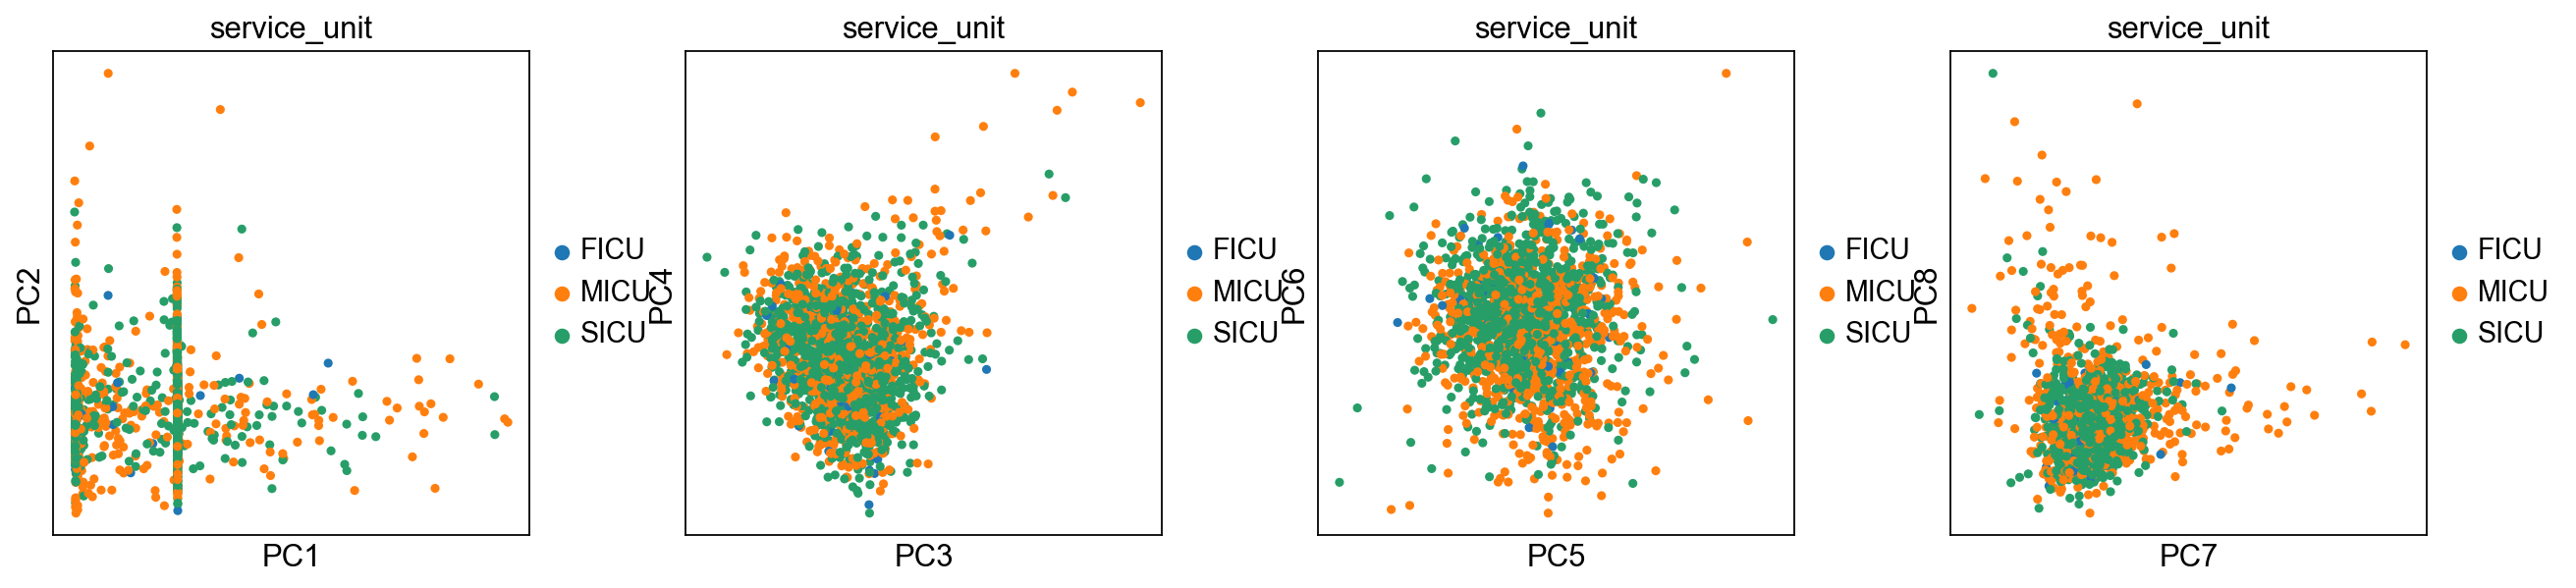

In [29]:
ep.settings.set_figure_params(figsize=(4, 4))
ep.pl.pca(adata, color="service_unit", components= ["1,2", "3,4", "5,6", "7,8"])

To inspect certain PCs further, we can inspect the PC dimensionality loadings which highlight the features that contribute strongest to the selected PC.

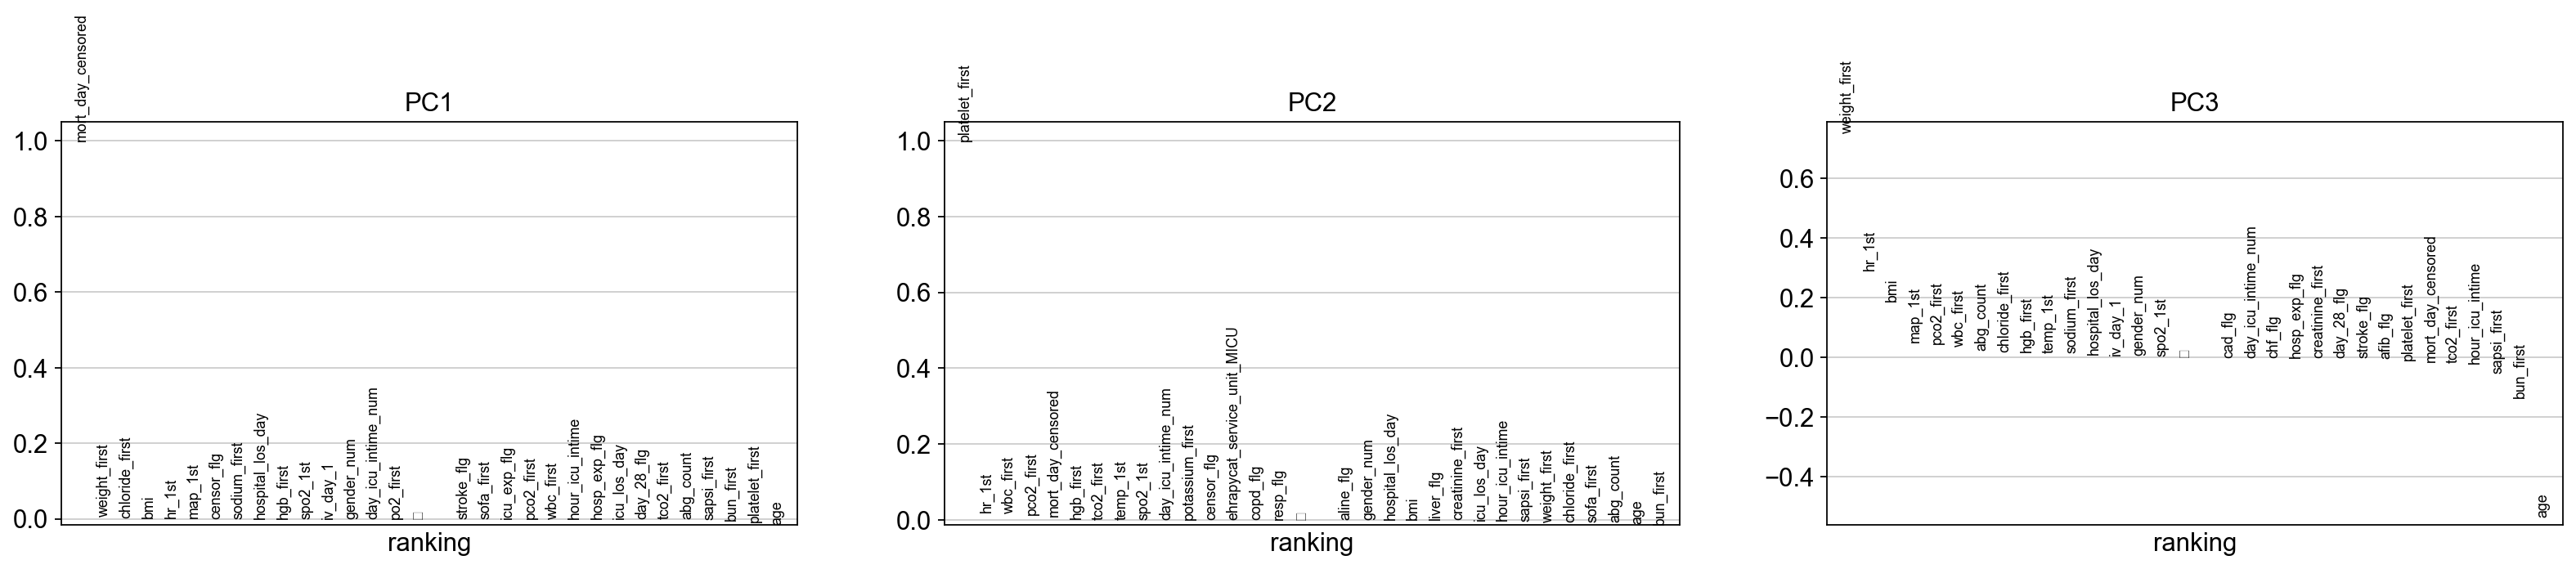

In [30]:
ep.settings.set_figure_params(figsize=(8, 4))
ep.pl.pca_loadings(adata, components='1,2,3')

#### Uniform Manifold Approximation and Projection (UMAP) 

The reduced representation can then be used as input for the neighbours graph calculation which serves as the input for advanced embeddings and visualizations like [Uniform Manifold Approximation and Projection (UMAP) ](https://umap-learn.readthedocs.io/en/latest/)

In [31]:
ep.pp.neighbors(adata, n_pcs=10)

In [32]:
ep.tl.umap(adata)

### Checking for Batch effects

Before exploring the data further, we need to see if we have a batch effect. A batch effect can e.g. arise from different collection units or collection days. To check if our data contains a batch for those feautures, we visualize the **service_unit** and the **day_icu_intime**.

If a batch effect is present, we can use the *pp.combat()* to remove effects.

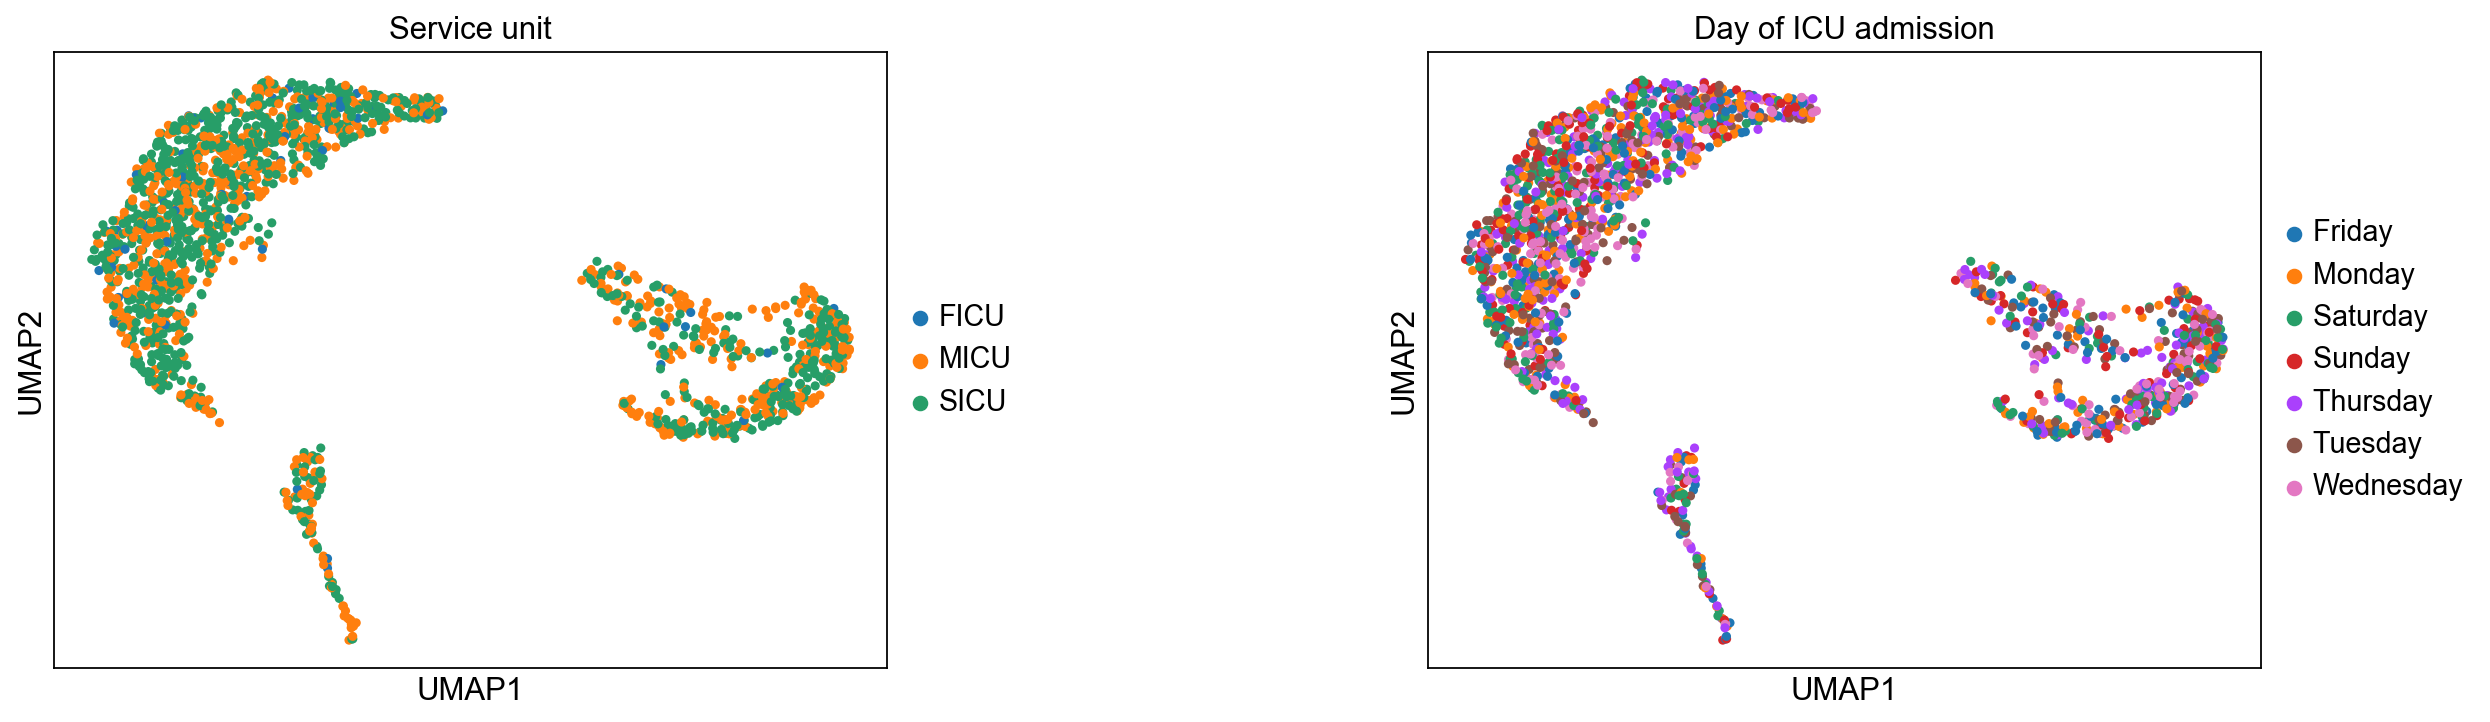

In [33]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(
    adata,
    color=["service_unit", "day_icu_intime", ],
    wspace=0.5,
    title=["Service unit", "Day of ICU admission"],
)

The embeddings suggest that there's no strong effect by the aforementioned potential confounders.

### Selected features on UMAP

Now we can also highlight other relevant feautres on the UMAP. Interesting features could be demographics, hospital statistics and lab parameters.

#### Demographics

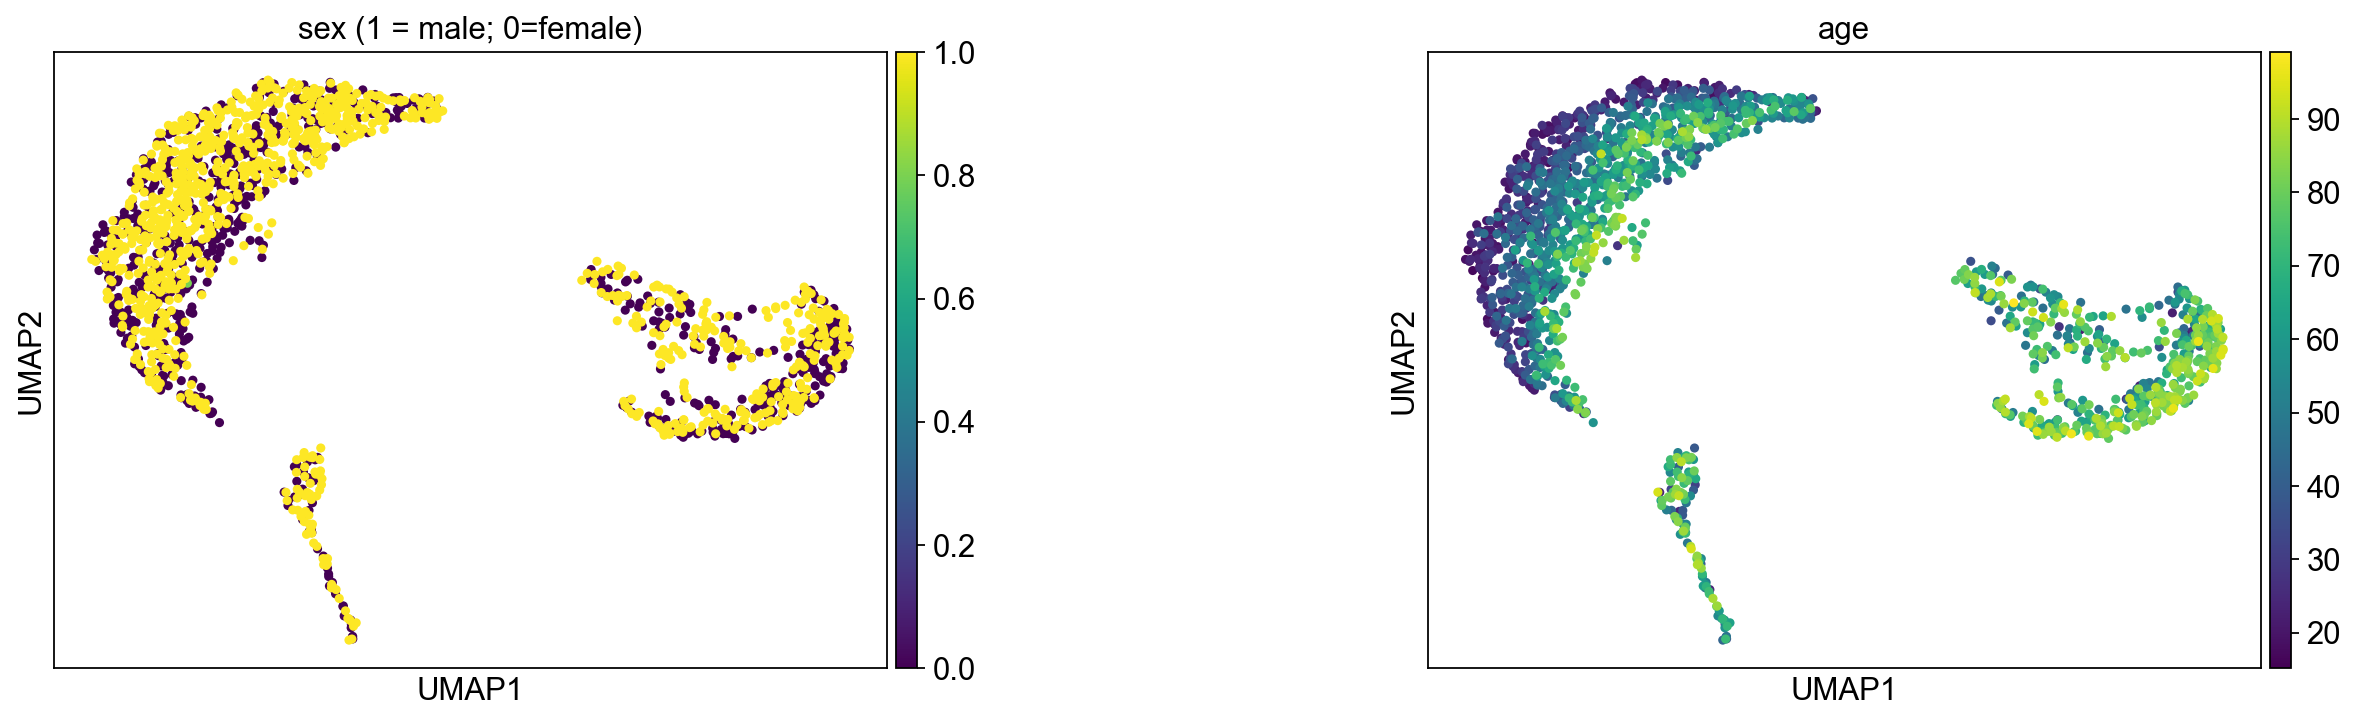

In [34]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(
    adata,
    color=["gender_num", "age"],
    wspace=0.5,
    title=["sex (1 = male; 0=female)", "age"],
)

#### Hospital statistics

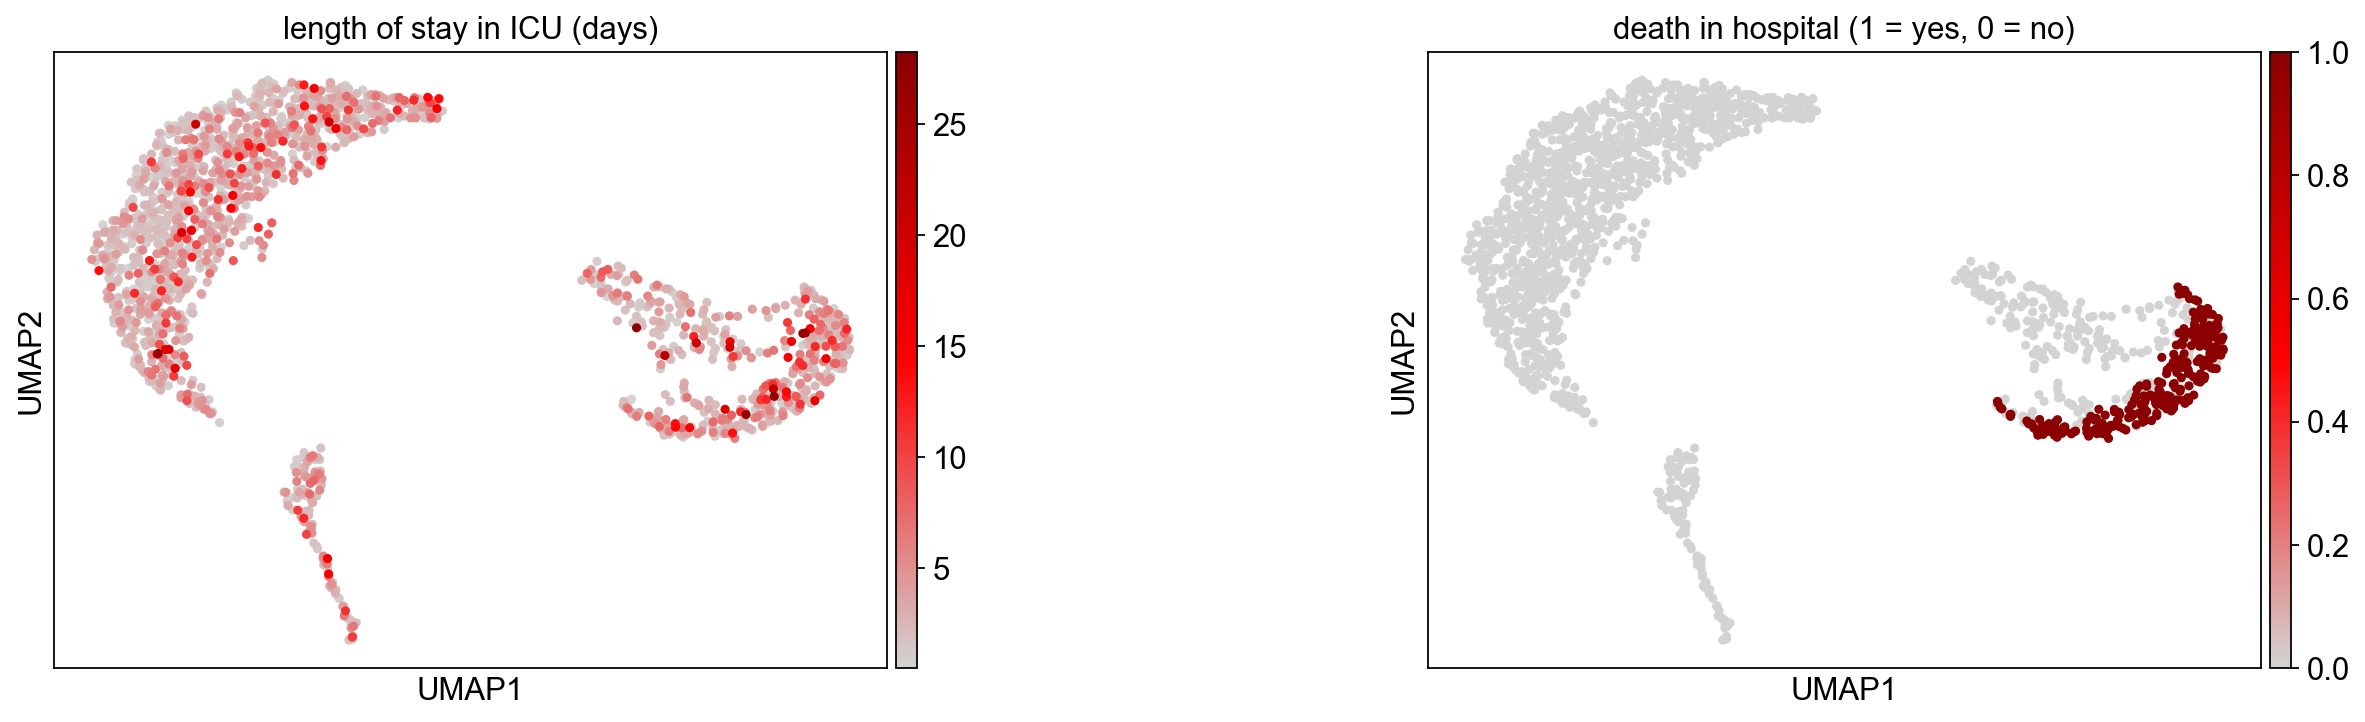

In [35]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(
    adata,
    color=["icu_los_day", "hosp_exp_flg"],
    wspace=0.5,
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["length of stay in ICU (days)", "death in hospital (1 = yes, 0 = no)"],
)

#### Comorbidities

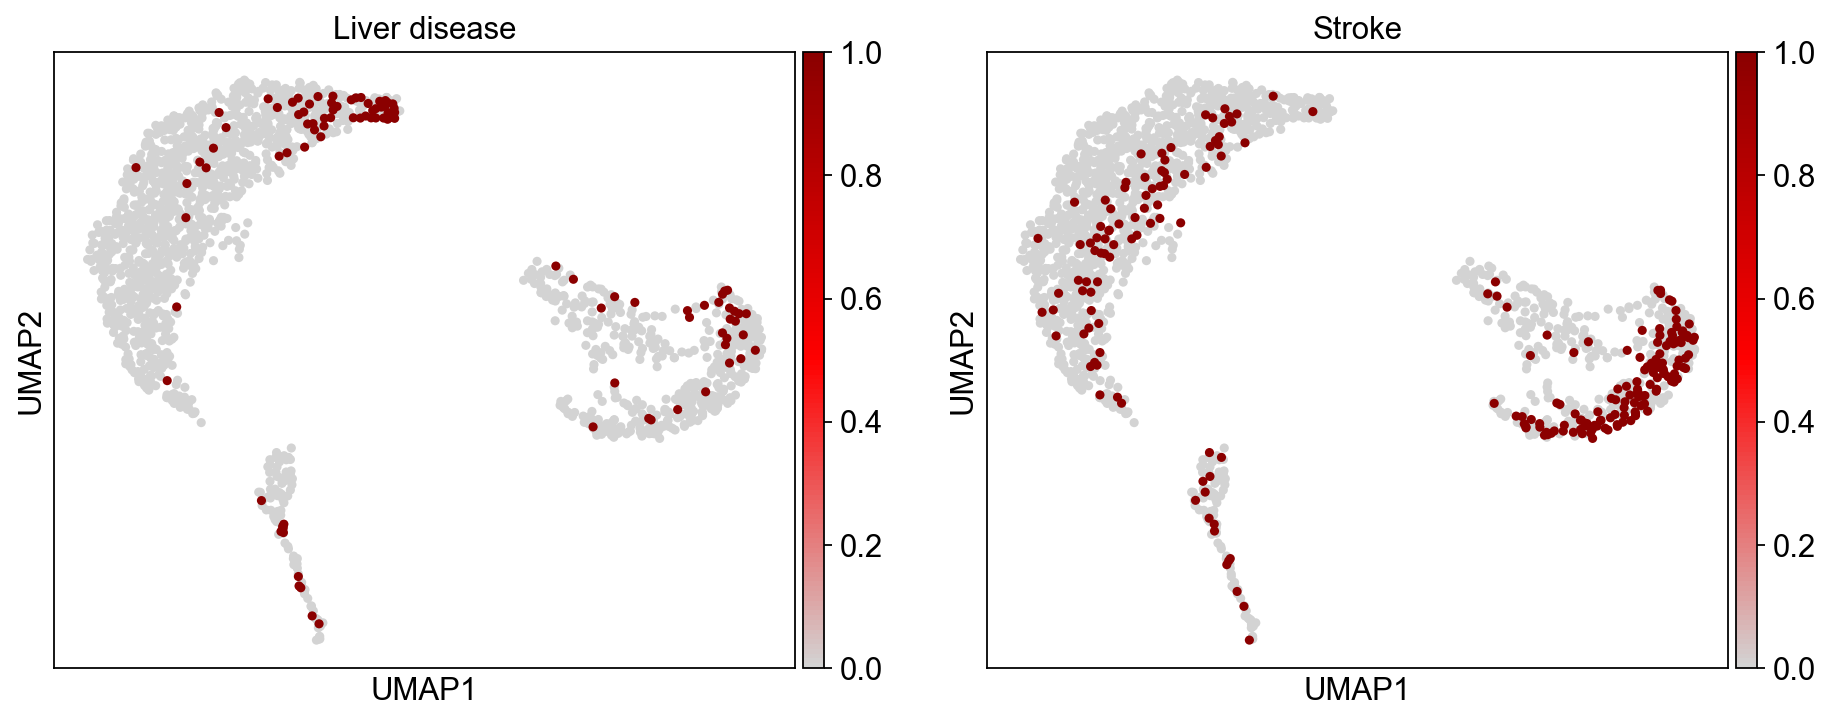

In [36]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(
    adata,
    color=["liver_flg", "stroke_flg"],
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["Liver disease", "Stroke"],
    ncols=2
)

#### Lab parameters

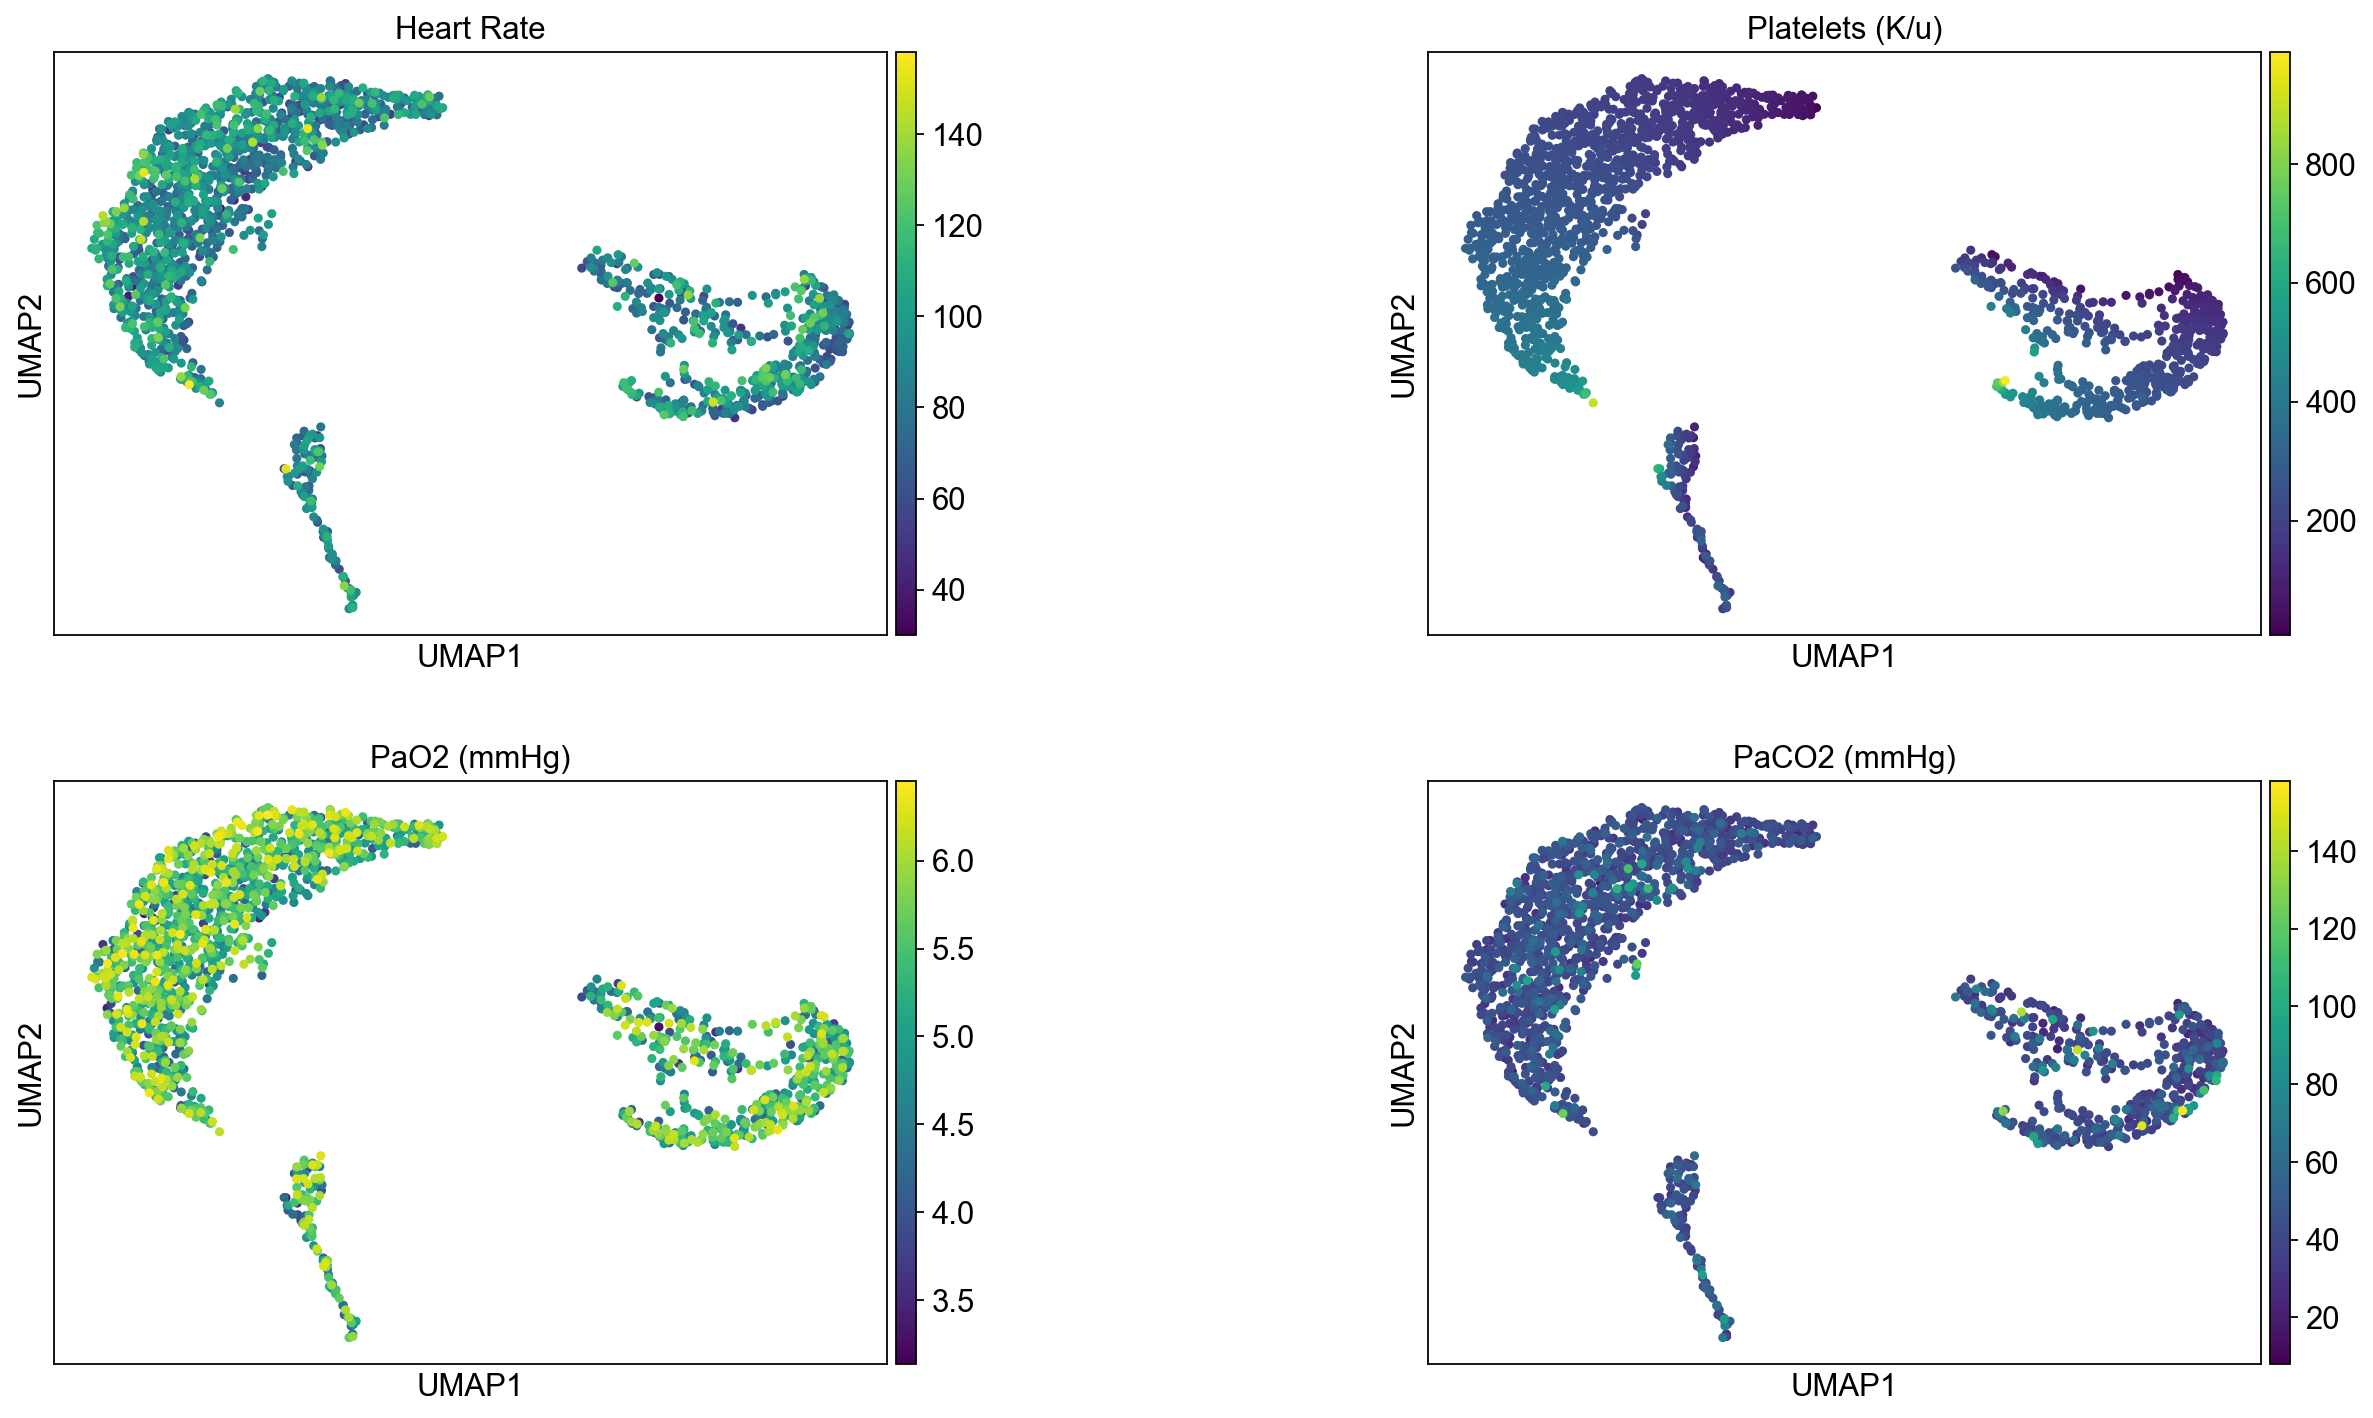

In [37]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(
    adata,
    color=["hr_1st","platelet_first", "po2_first",  "pco2_first"],
    wspace=0.5, ncols = 2,
    title=["Heart Rate","Platelets (K/u)", "PaO2 (mmHg)",  "PaCO2 (mmHg)"],
)

### Cluster analysis

To make more sense of the embedding it is often times useful to determine clusters through e.g. community detection as implemented in the [Leiden algorithm](https://www.nature.com/articles/s41598-019-41695-z). Moreover, clustering allows for unbiased detection of features that are changed between clusters and therefore intersting for us.  

#### Cluster identification

The implementation in ehrapy allows for the setting of a resolution which determines the number of found clusters. It is often times useful to play around with the parameter.

In [38]:
ep.tl.leiden(adata, resolution=0.3, key_added="leiden_0_3")

The leiden algorithm added a key to **obs** (`leiden_0_3`) that stores the clusters. These can subsequently be visualized in the UMAP embedding.

In [39]:
adata.obs.head(4)

service_unit day_icu_intime  missing_values_abs  missing_values_pct  \
0         SICU      Friday                      0                 0.0   
1         MICU      Saturday                    0                 0.0   
2         MICU      Friday                      0                 0.0   
3         SICU      Saturday                    0                 0.0   

  leiden_0_3  
0          2  
1          1  
2          1  
3          2

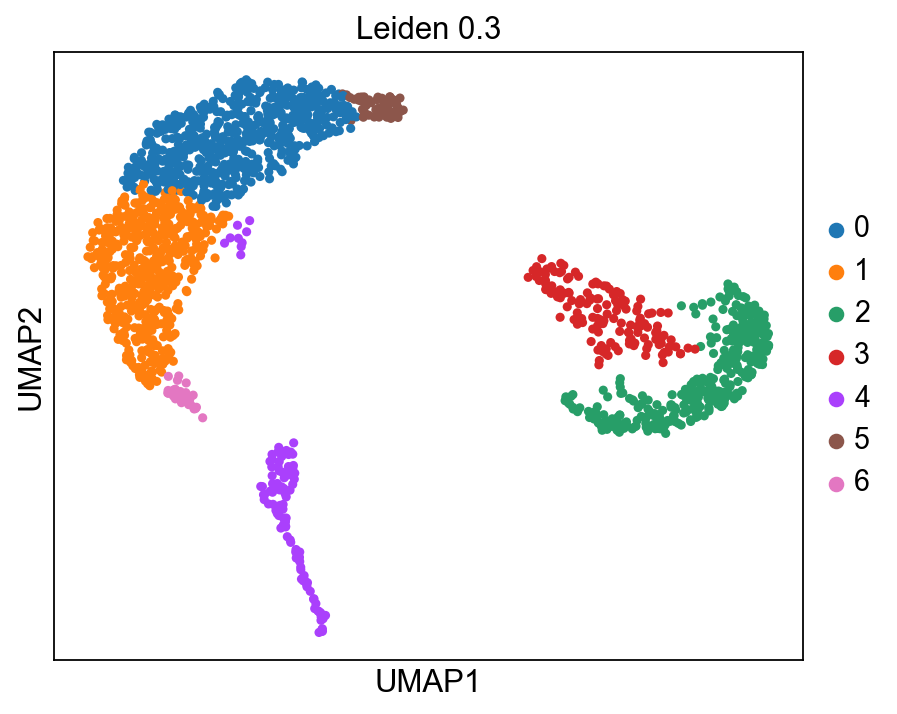

In [40]:
ep.pl.umap(adata, color=["leiden_0_3"], title="Leiden 0.3")

Next, we can explore certain features which are special for certrain clusters and could therefore be used for annotation.

#### Cluster features

To identify cluster-specific markers, ehrapy provides the *ep.tl.rank_features_groups()* function, which allows statistical tests between the cluster groups to determine significantly enriched or lowered values.

In [41]:
ep.tl.rank_features_groups(adata, groupby="leiden_0_3")

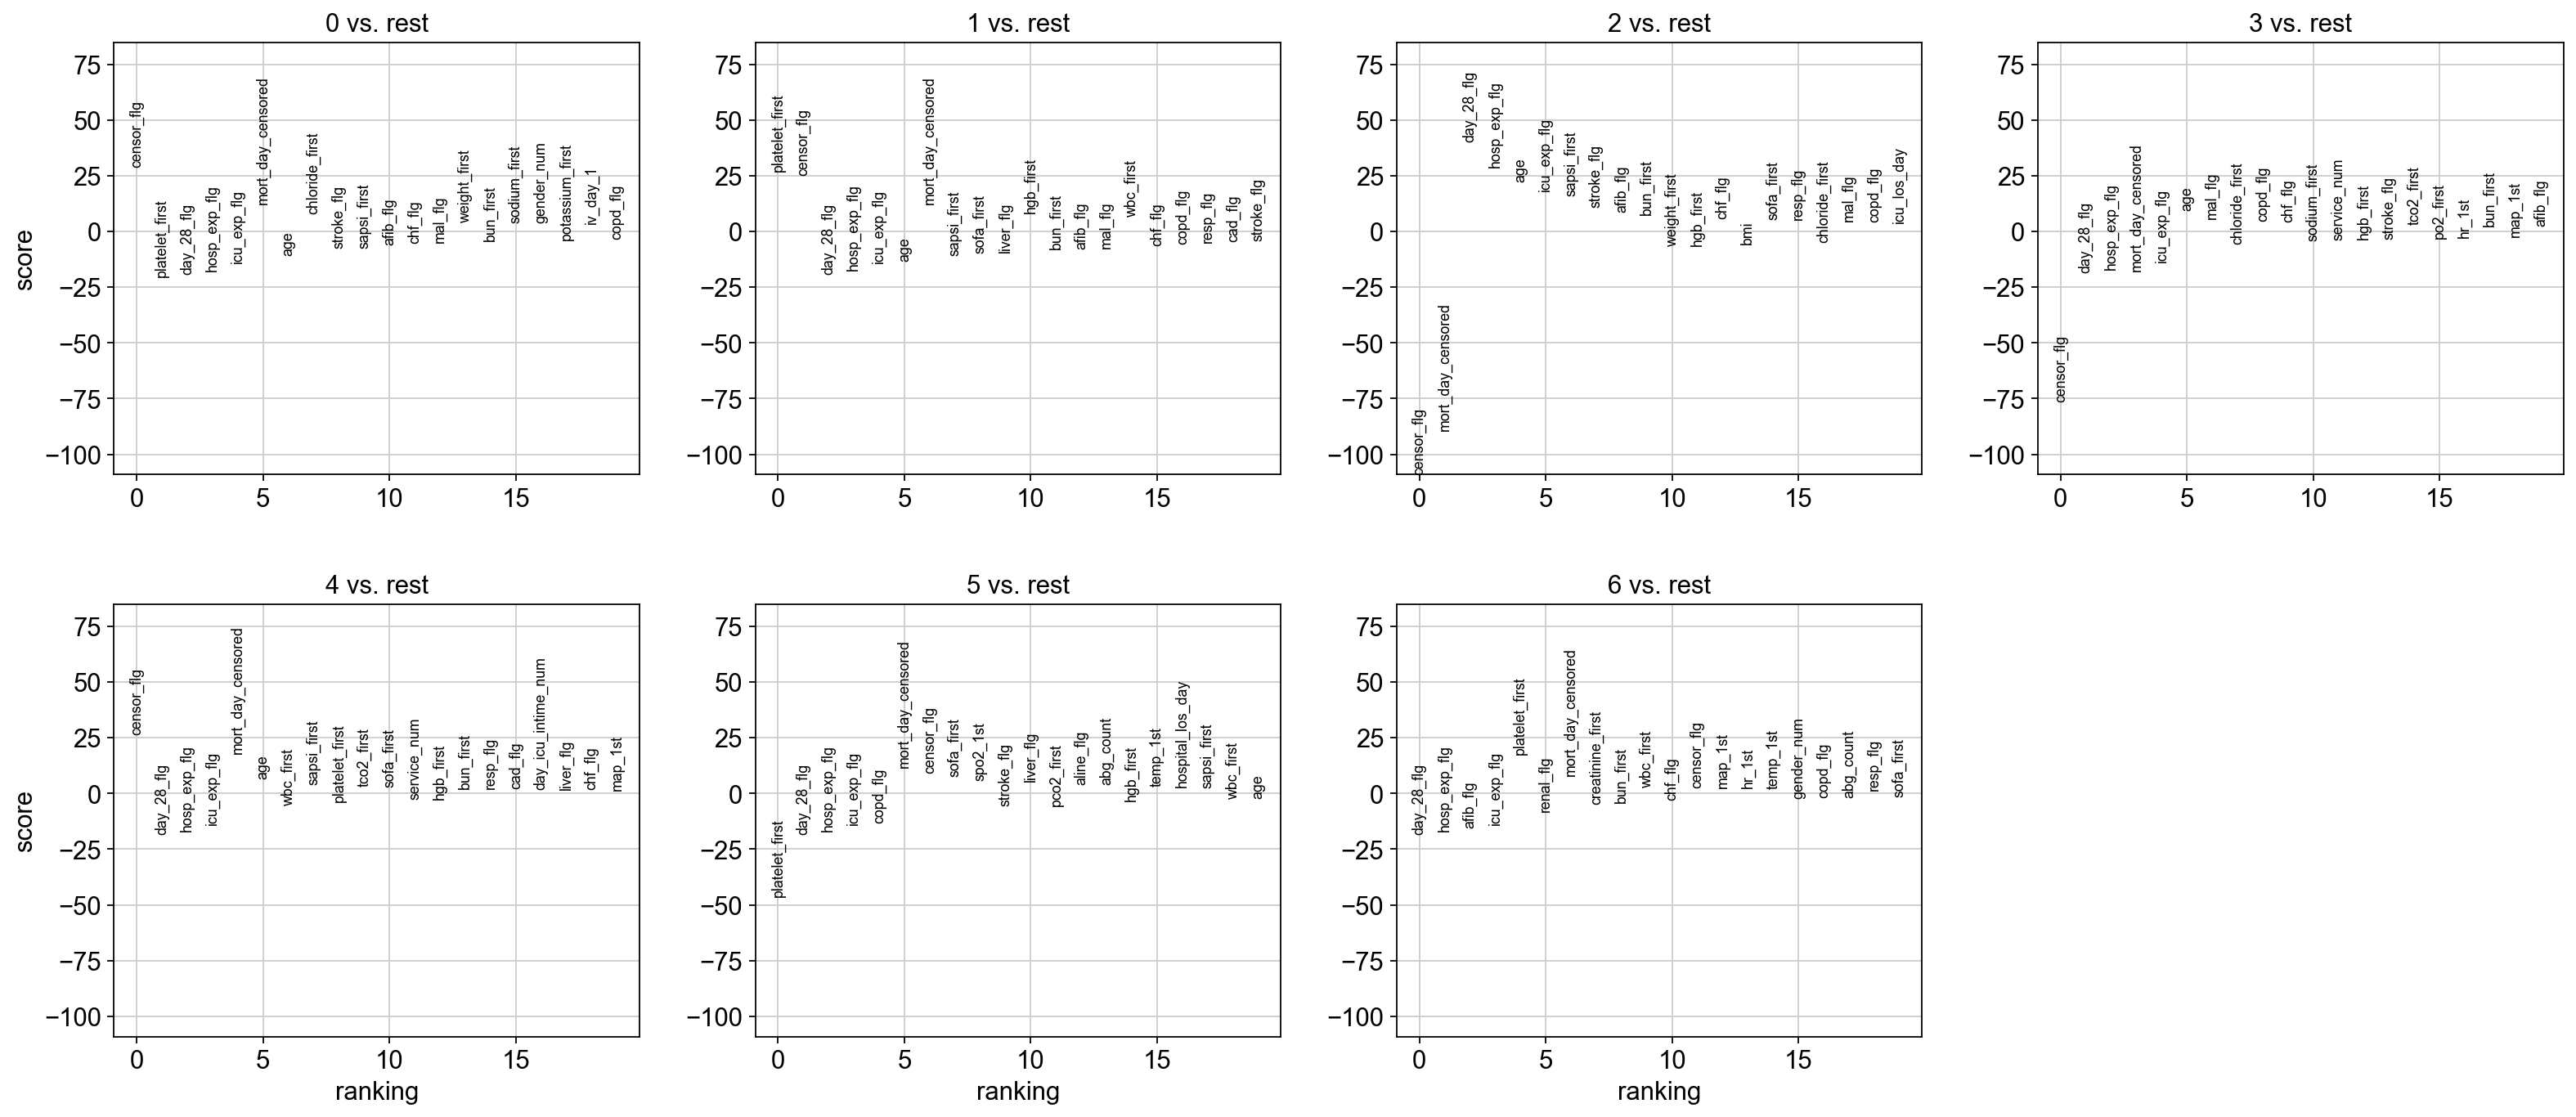

In [42]:
ep.pl.rank_features_groups(adata, key="rank_features_groups", ncols = 4)

We can also get the top features per cluster as a DataFrame.

In [43]:
df = ep.ad.get_rank_features_df(adata, group=["0", "1", "2", "3", "4", "5", "6"])
df = df.loc[(df["logfoldchanges"] > 0) & (df["pvals_adj"] < 0.05), ]

E.g. we can check the top marker of cluster 2.

In [44]:
df.loc[df["group"] == "2", ]

group            names     scores  logfoldchanges          pvals  \
90      2       day_28_flg  40.163418       30.255802  1.602011e-131   
91      2     hosp_exp_flg  29.032896       29.949463   2.669161e-94   
92      2              age  22.384300       32.357395   5.525346e-82   
93      2      icu_exp_flg  18.332195       29.256935   9.043693e-53   
94      2      sapsi_first  16.116190        5.267409   5.856240e-48   
95      2       stroke_flg  10.808780        2.592192   5.484350e-24   
96      2         afib_flg   8.854611        2.218182   2.853562e-17   
97      2        bun_first   7.671074       11.443713   1.161684e-13   
100     2          chf_flg   5.822193        1.433449   1.151670e-08   
102     2       sofa_first   5.543683        1.169838   4.843230e-08   
103     2         resp_flg   5.389370        0.754994   1.104212e-07   
105     2          mal_flg   4.514720        1.007265   8.127339e-06   
106     2         copd_flg   4.397418        1.280134   1.387258e-05   
107     2      icu_los_day   3.928232        1.416589   9.959582e-05   
109     2       tco2_first   3.041532        1.463894   2.487531e-03   
111     2          cad_flg   2.846287        0.938949   4.630552e-03   
112     2  potassium_first   2.670771        0.201073   7.825826e-03   
113     2        abg_count   2.405999        2.330037   1.656540e-02   

         pvals_adj  
90   2.349616e-130  
91    2.936077e-93  
92    4.862305e-81  
93    6.632041e-52  
94    3.681065e-47  
95    3.016393e-23  
96    1.395075e-16  
97    5.111410e-13  
100   3.897962e-08  
102   1.420681e-07  
103   3.036582e-07  
105   1.986683e-05  
106   3.212598e-05  
107   2.191108e-04  
109   4.975061e-03  
111   8.489346e-03  
112   1.377345e-02  
113   2.803375e-02

From this table we can also extract the top features in every cluster and highlight those either on the UMAP or as violins plots by cluster.

In [45]:
top_features = df.groupby("group").head(5)
top_features = pd.Series(top_features["names"].unique())
top_features

0            censor_flg
1     mort_day_censored
2        chloride_first
3          weight_first
4          sodium_first
5        platelet_first
6             hgb_first
7             wbc_first
8            day_28_flg
9          hosp_exp_flg
10                  age
11          icu_exp_flg
12          sapsi_first
13              mal_flg
14             copd_flg
15              chf_flg
16           tco2_first
17           sofa_first
18             spo2_1st
19            liver_flg
20              map_1st
dtype: object

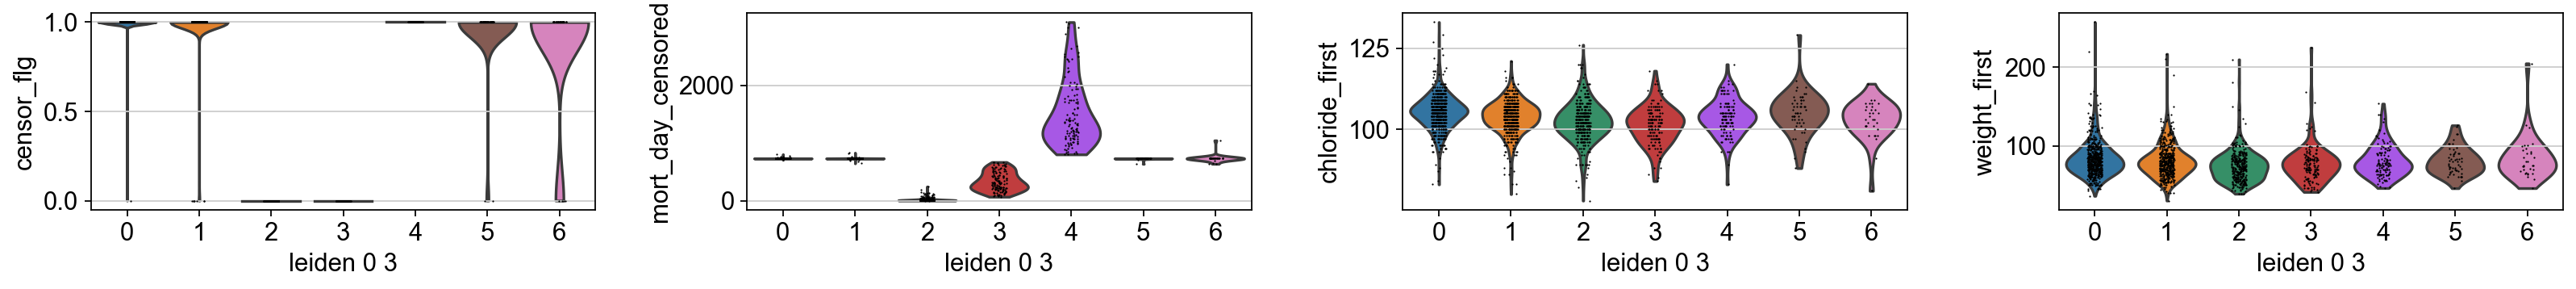

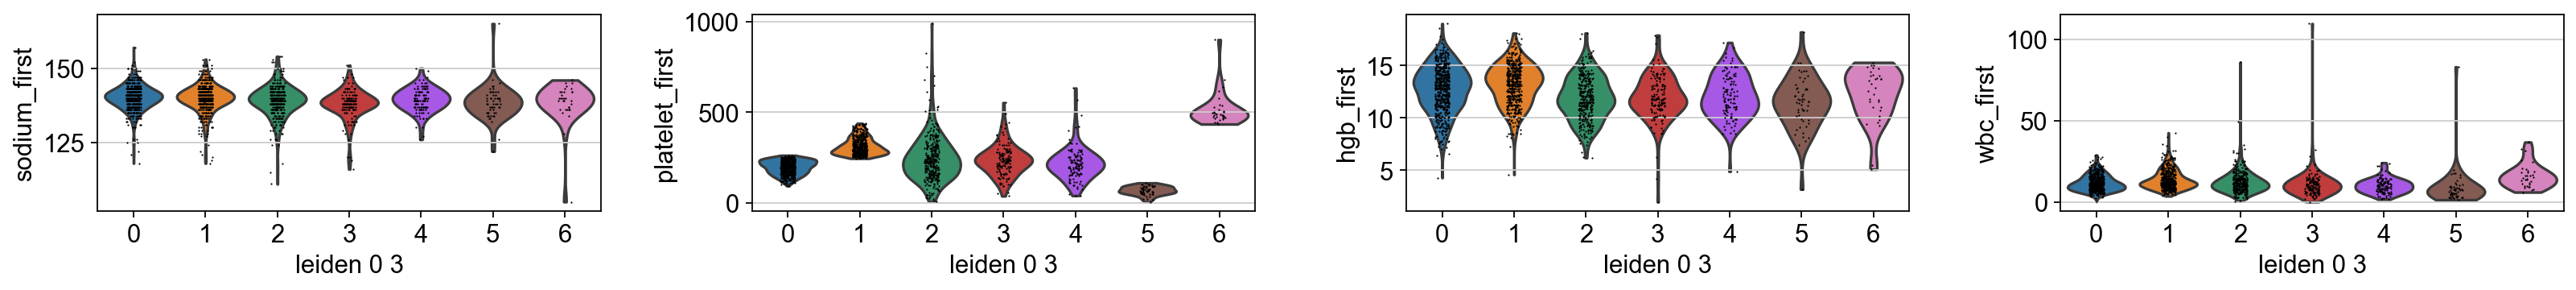

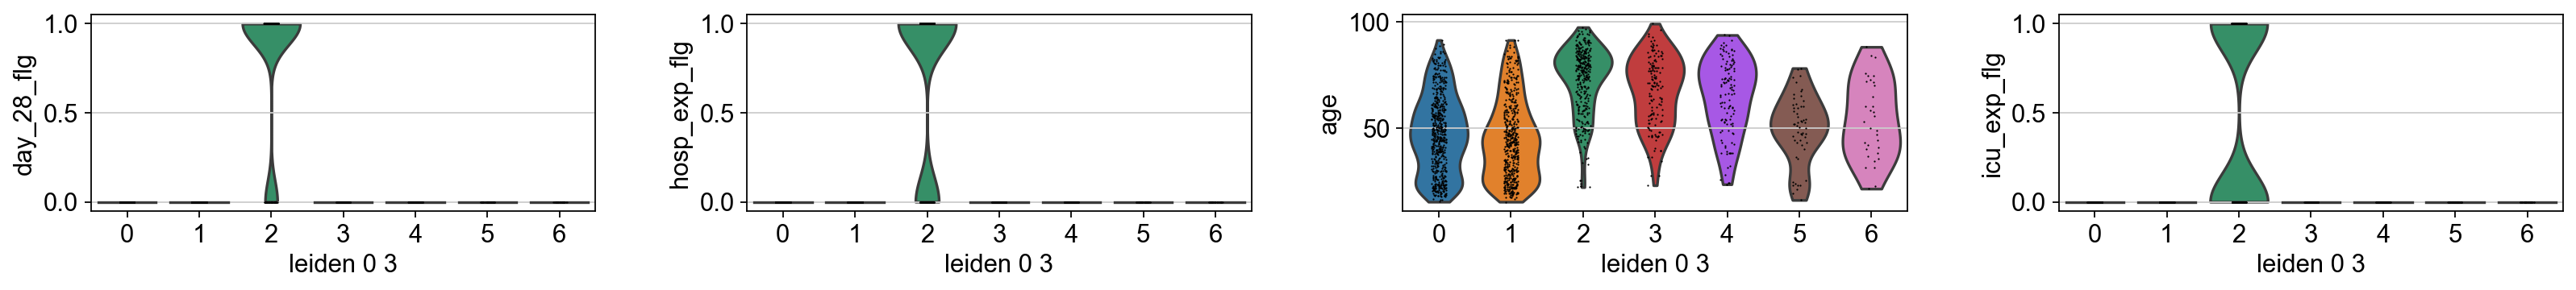

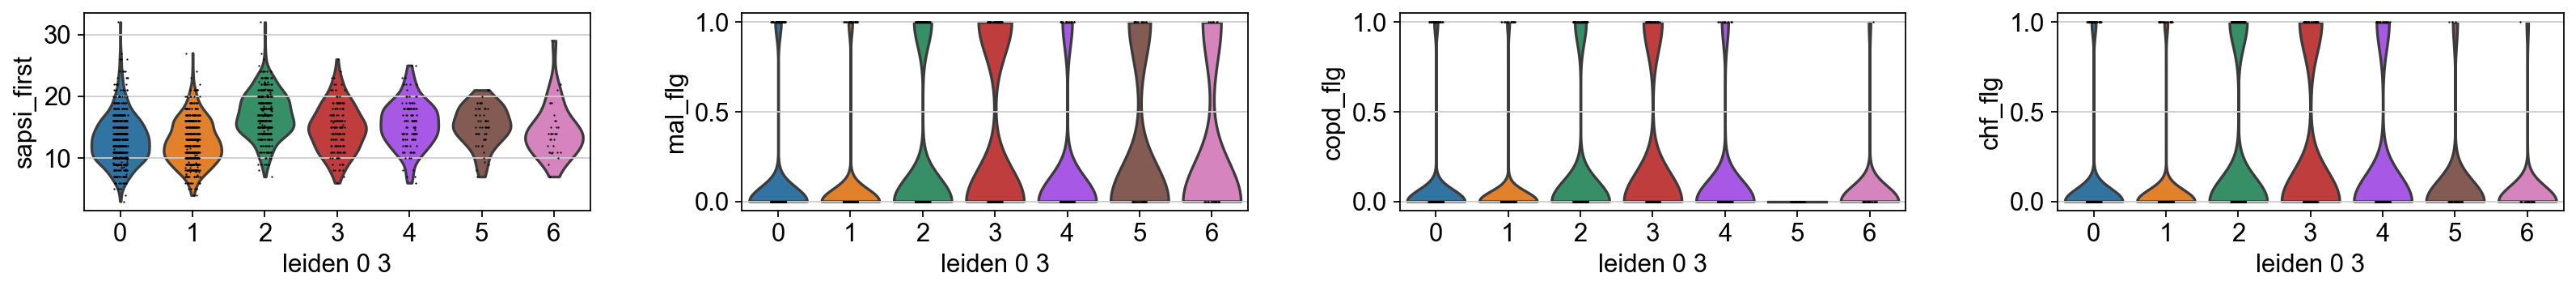

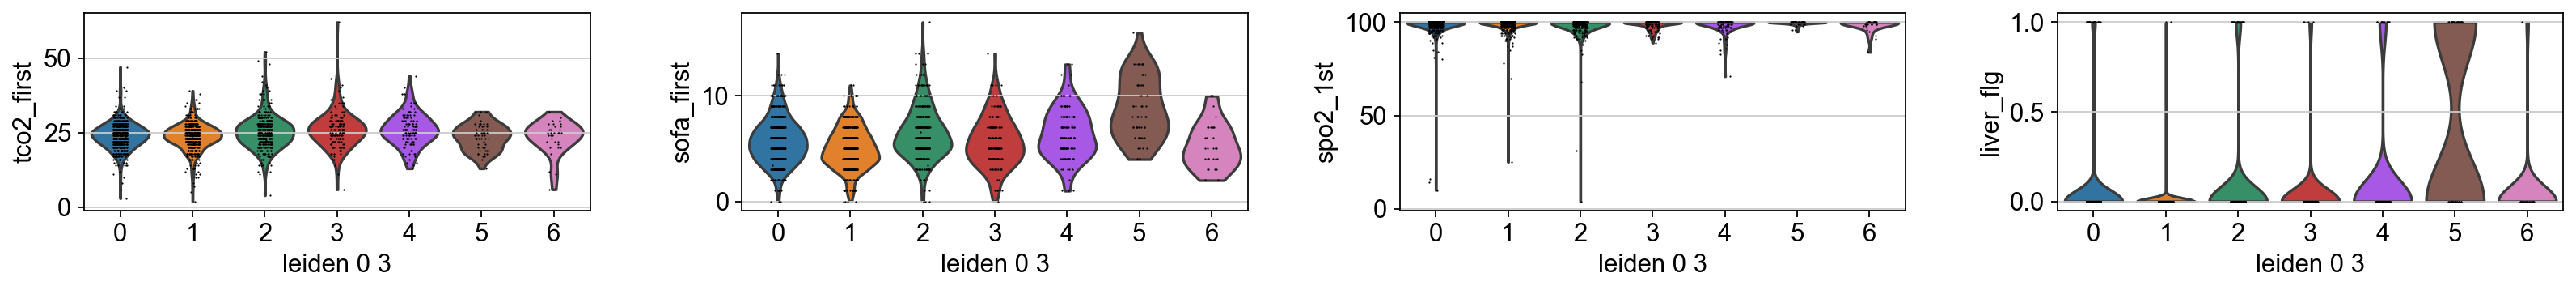

In [46]:
ep.settings.set_figure_params(figsize=(5, 2))
ep.pl.violin(adata, keys=top_features[0:4], groupby = "leiden_0_3")
ep.pl.violin(adata, keys=top_features[4:8], groupby = "leiden_0_3")
ep.pl.violin(adata, keys=top_features[8:12], groupby = "leiden_0_3")
ep.pl.violin(adata, keys=top_features[12:16], groupby = "leiden_0_3")
ep.pl.violin(adata, keys=top_features[16:20], groupby = "leiden_0_3")

#### Cluster annotation

With the knowledge of the cluster features, together with the UMAP plots from above we can annotate the clusters.

In [47]:
adata.obs["annotation"] = "NA"

In [48]:
annotation = {
    "0": "weight+",
    "1": "platelet+",
    "2": "age+/stroke+/deceased+",
    "3": "age+/malignancy+/copd+",
    "4": "age+/late_deceased+",
    "5": "liver+/sofa+",    
    "6": "platelet+/heart_rate+"

}

In [49]:
adata.obs["annotation"] = [
    annotation[l] if l in annotation.keys() else l for l in adata.obs["leiden_0_3"]
]

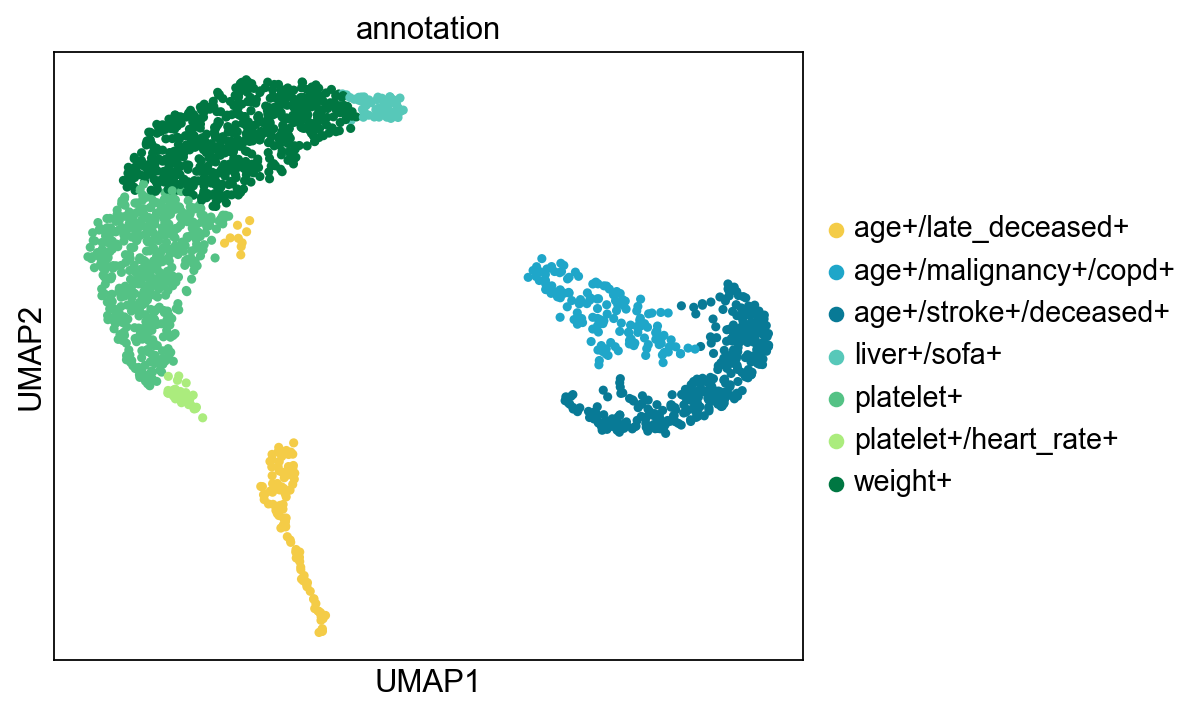

In [50]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(adata, color="annotation", palette= {
    "weight+": "#007742",
    "platelet+": "#54C285",
    "age+/stroke+/deceased+": "#087A96",
    "age+/malignancy+/copd+": "#1FA6C9",
    "age+/late_deceased+": "#F4CC47",
    "liver+/sofa+": "#57C8B9",    
    "platelet+/heart_rate+": "#ABEC7D"
})

### Additional downstream analysis 

After these basic ehrapy analysis steps, additional downstream analysis can be performed (see also other tutorials). 

#### PAGA

It might also be of interest to infer trajectories to learn about dynamic processes and stage transitions.
ehrapy offers several [trajectory inference](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#clustering-and-trajectory-inference) algorithms for this purpose. One of those is partition-based graph abstraction (PAGA).

In [51]:
ep.tl.paga(adata, groups="leiden_0_3")

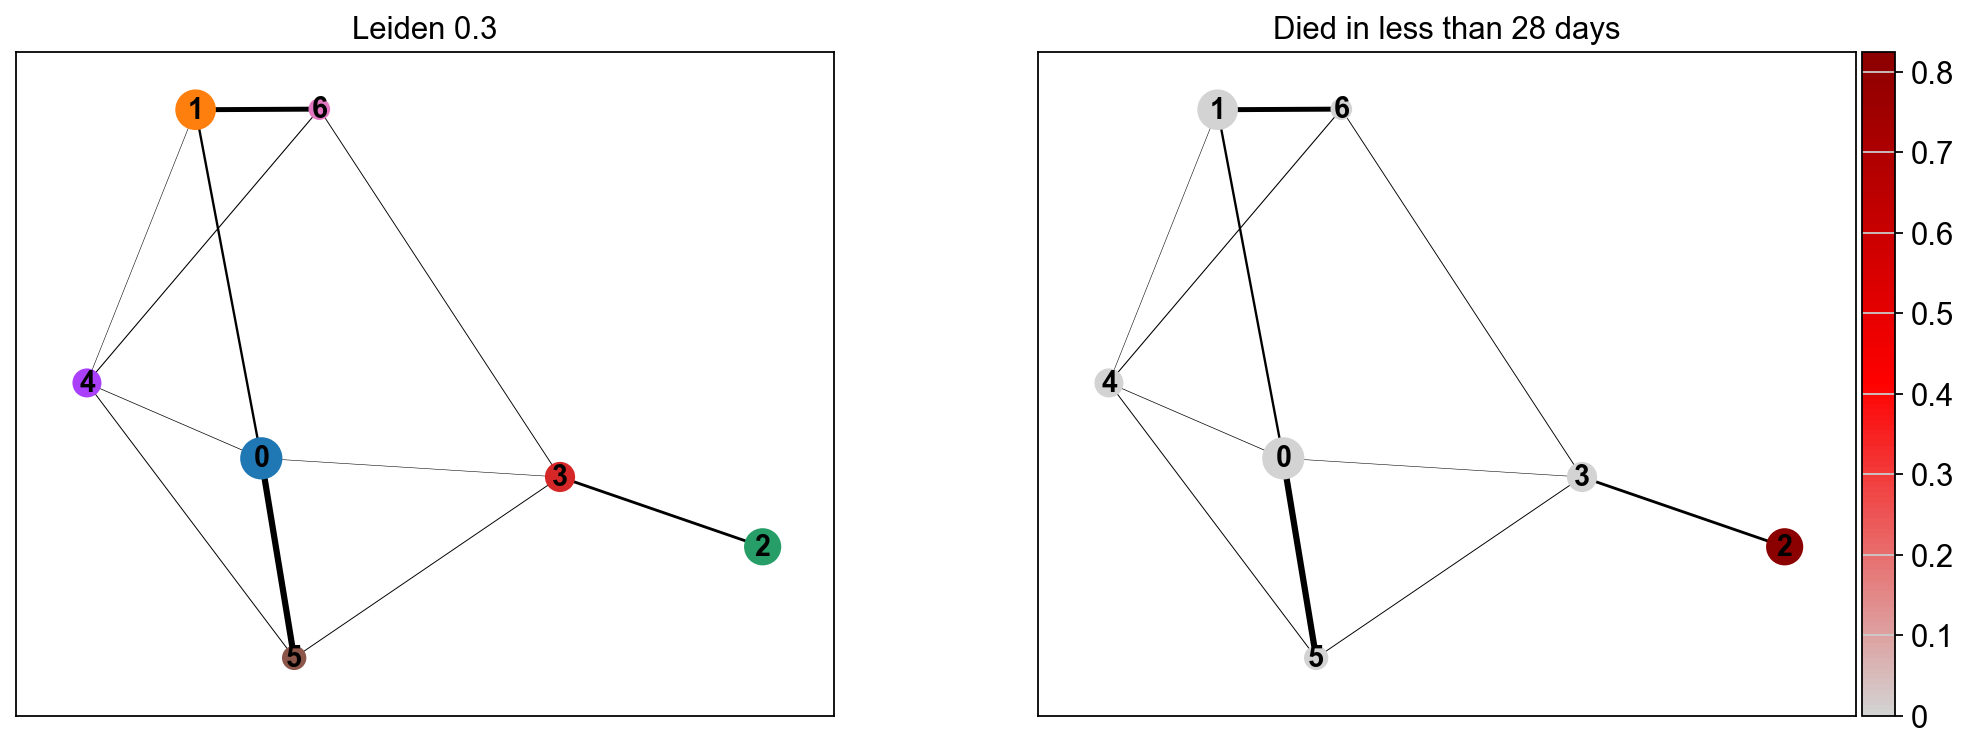

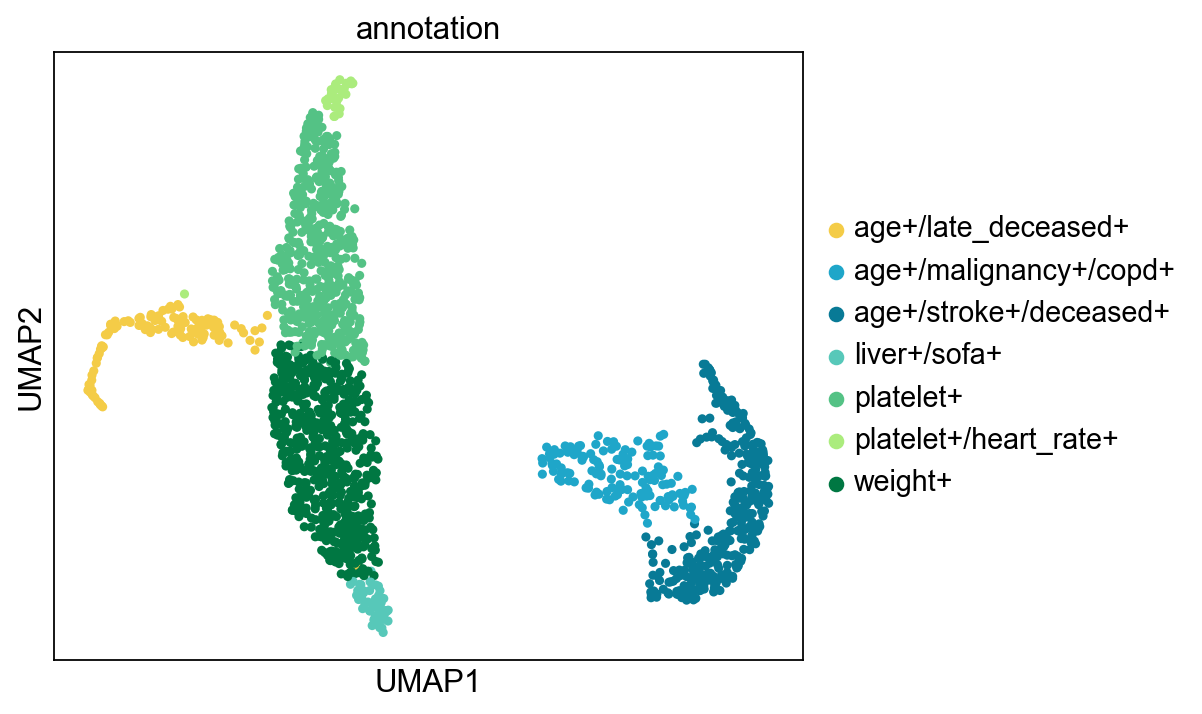

In [52]:
ep.pl.paga(
    adata,
    color=["leiden_0_3", "day_28_flg"],
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["Leiden 0.3", "Died in less than 28 days"],
)

ep.tl.umap(adata, init_pos="paga")
ep.pl.umap(adata, color=["annotation"])

In [53]:
ep.tl.draw_graph(adata, init_pos="paga")

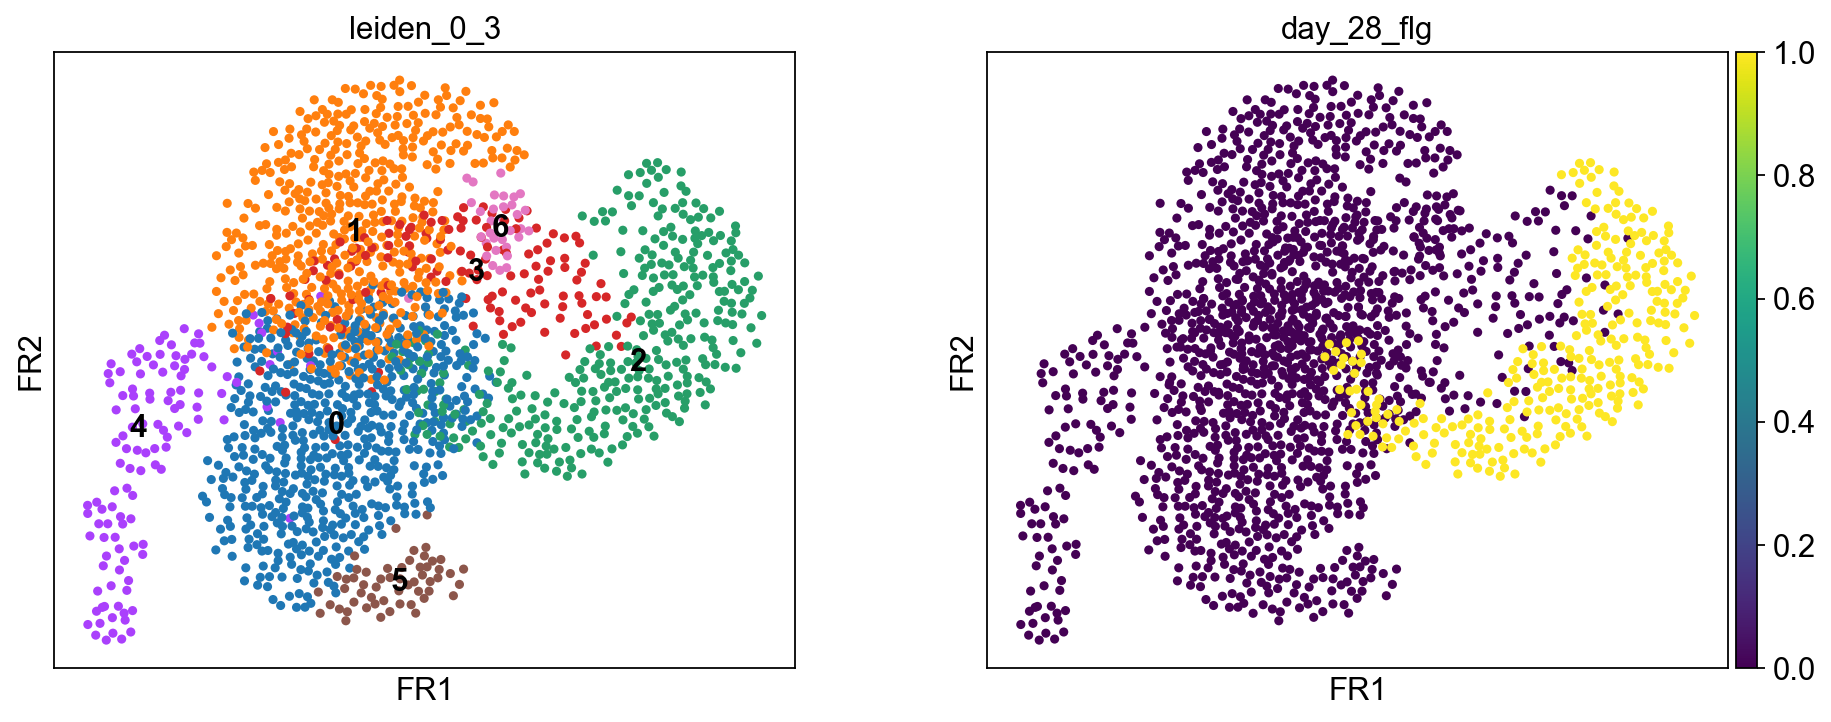

In [54]:
ep.pl.draw_graph(adata, color=["leiden_0_3", "day_28_flg"], legend_loc="on data")

## Exporting results

We save all of our computations and our final state into an `.h5ad` file. It can then be read again using the *ep.io.read()* function, e.g. like this: `ep.io.read("mimic_2.h5ad", adata)`

In [55]:
ep.io.write("mimic_2.h5ad", adata)

## Conclusion

to be added

## References

* Raffa, J. (2016). Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters (version 1.0). PhysioNet. https://doi.org/10.13026/C2NC7F.

* Raffa J.D., Ghassemi M., Naumann T., Feng M., Hsu D. (2016) Data Analysis. In: Secondary Analysis of Electronic Health Records. Springer, Cham

* Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

* McInnes et al., (2018). UMAP: Uniform Manifold Approximation and Projection. Journal of Open Source Software, 3(29), 861, https://doi.org/10.21105/joss.00861

* Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

* Wolf, F.A., Hamey, F.K., Plass, M. et al. PAGA: graph abstraction reconciles clustering with trajectory inference through a topology preserving map of single cells. Genome Biol 20, 59 (2019). https://doi.org/10.1186/s13059-019-1663-x

## Package versions

In [56]:
ep.print_versions( )

-----
ehrapy              0.5.0
rich                NA
session_info        1.0.0
-----
Levenshtein         0.21.1
PIL                 9.5.0
anndata             0.9.1
astor               0.8.1
asttokens           NA
attr                23.1.0
autograd            NA
autograd_gamma      NA
backcall            0.2.0
bs4                 4.12.2
cachetools          5.3.1
category_encoders   2.6.1
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
colorama            0.4.6
comm                0.1.3
cvxopt              1.3.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
db_dtypes           1.1.1
debugpy             1.6.7
decorator           5.1.1
deep_translator     1.9.1
deepl               1.15.0
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
fhiry               3.0.0
formulaic           0.6.2
future              0.18.3
google              NA
grpc                1.56.0
grpc_status         NA
h5py                3.9.0
idna                3.4
igraph              0.10.4
interface_meta      1.3.0
ipykernel           6.23.3
ipython_genutils    0.2.0
ipywidgets          8.0.6
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
lifelines           0.27.7
llvmlite            0.40.1
matplotlib          3.7.1
matplotlib_inline   0.1.6
missingno           0.5.2
mpl_toolkits        NA
natsort             8.4.0
networkx            3.1
numba               0.57.1
numpy               1.24.3
packaging           23.1
pandas              2.0.2
parso               0.8.3
patsy               0.5.3
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.8.0
prompt_toolkit      3.0.38
psutil              5.9.5
pure_eval           0.2.2
pyarrow             12.0.1
pyasn1              0.5.0
pyasn1_modules      0.3.0
pycparser           2.21
pydev_ipython       NA
pydevconsole        NA
pydevd              2.9.5
pydevd_file_utils   NA
pydevd_plugins      NA
pydevd_tracing      NA
pygments            2.15.1
pynndescent         0.5.10
pyparsing           3.1.0
pythoncom           NA
pytz                2023.3
pywin32_bootstrap   NA
pywin32_system32    NA
pywintypes          NA
rapidfuzz           3.1.1
requests            2.31.0
rsa                 4.9
scanpy              1.9.3
scipy               1.11.0
seaborn             0.12.2
setuptools          68.0.0
six                 1.16.0
sklearn             1.2.2
soupsieve           2.4.1
stack_data          0.6.2
statsmodels         0.14.0
texttable           1.6.7
thefuzz             0.19.0
threadpoolctl       3.1.0
tornado             6.3.2
tqdm                4.65.0
traitlets           5.9.0
typing_extensions   NA
umap                0.5.3
urllib3             1.26.16
wcwidth             0.2.6
win32api            NA
win32com            NA
wrapt               1.15.0
yaml                6.0
zmq                 24.0.1
-----
IPython             8.14.0
jupyter_client      7.4.9
jupyter_core        5.3.1
notebook            6.5.4
-----
Python 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Windows-10-10.0.19044-SP0
-----
Session information updated at 2023-07-03 13:57